# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 8  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

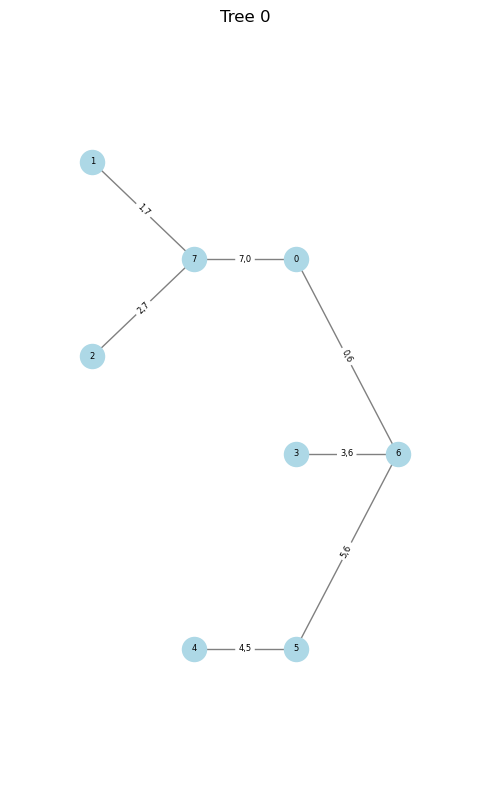

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2026-01-10 20:40:21,069] A new study created in RDB with name: no-name-89a164b4-b214-465c-b4bc-4c99aff48cc6
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<10:09,  3.28it/s]

current_loss: tensor(1.4397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.428974986076355
current_loss: tensor(1.4352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4216272830963135
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.8115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4204882383346558
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<01:49, 18.17it/s]

current_loss_val:  1.4188995361328125
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4177991151809692
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.418052077293396
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4178874492645264
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4178560972213745
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.417771339416504
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackw

  1%|          | 15/2000 [00:00<01:23, 23.79it/s]

current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4174319505691528
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4174957275390625
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4174885749816895
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4173009395599365
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward

  1%|          | 18/2000 [00:00<01:22, 24.14it/s]

current_loss_val:  1.4172735214233398
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4170217514038086
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4169869422912598
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4169965982437134
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4169944524765015
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, 

  1%|          | 22/2000 [00:01<01:40, 19.75it/s]


current_loss_val:  1.4170219898223877
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4170161485671997
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4170303344726562
Early Stop at iteration 22 with minimal loss tensor(1.4170, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<05:55,  5.63it/s]

current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3319287300109863
current_loss: tensor(1.3408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1901612281799316
current_loss: tensor(1.2089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1863, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:57, 11.21it/s]

current_loss_val:  1.1677166223526
current_loss: tensor(1.1863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1478652954101562
current_loss: tensor(1.1678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1245877742767334
current_loss: tensor(1.1490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1340, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:42, 12.27it/s]

current_loss_val:  1.1023428440093994
current_loss: tensor(1.1340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0856720209121704
current_loss: tensor(1.1228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0787007808685303
current_loss: tensor(1.1170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1085, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:33, 12.95it/s]

current_loss_val:  1.0632063150405884
current_loss: tensor(1.1085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.057065725326538
current_loss: tensor(1.1025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1004, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:36, 12.70it/s]

current_loss_val:  1.0554587841033936
current_loss: tensor(1.1004, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:31, 13.14it/s]

current_loss: tensor(1.0834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0435450077056885
current_loss: tensor(1.0834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0244262218475342
current_loss: tensor(1.0633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0204529762268066


  1%|          | 15/2000 [00:01<02:35, 12.80it/s]

current_loss: tensor(1.0594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0177419185638428
current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0081312656402588
current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:29, 13.26it/s]

current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9994996190071106


  1%|          | 19/2000 [00:01<02:33, 12.87it/s]

current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9984275102615356
current_loss: tensor(1.0318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9972643256187439
current_loss: tensor(1.0304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0252, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:29, 13.27it/s]

current_loss_val:  0.9941281676292419
current_loss: tensor(1.0252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.992068886756897
current_loss: tensor(1.0209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9923751950263977
current_loss: tensor(1.0196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0179, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:22, 13.88it/s]

current_loss_val:  0.9906964898109436
current_loss: tensor(1.0179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.989751398563385
current_loss: tensor(1.0164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9890087246894836
current_loss: tensor(1.0149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0143, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:20, 14.00it/s]

current_loss_val:  0.9915529489517212
current_loss: tensor(1.0143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9864181876182556
current_loss: tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9857531189918518
current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0084, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:18, 14.20it/s]

current_loss_val:  0.9855531454086304
current_loss: tensor(1.0084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9854155778884888
current_loss: tensor(1.0076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9851205945014954
current_loss: tensor(1.0070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0063, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:18, 14.19it/s]

current_loss_val:  0.9845647215843201
current_loss: tensor(1.0063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9834744334220886
current_loss: tensor(1.0047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9820191860198975
current_loss: tensor(1.0031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0010, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:17, 14.28it/s]

current_loss_val:  0.9803915023803711
current_loss: tensor(1.0010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9801725745201111
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.977898359298706
current_loss: tensor(0.9976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:02<02:17, 14.28it/s]

current_loss_val:  0.9774684906005859
current_loss: tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9773550033569336
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9775295853614807
current_loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:25, 13.50it/s]

current_loss: tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9773249626159668
current_loss: tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9773759245872498
current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:22, 13.76it/s]

current_loss_val:  0.9772284030914307
current_loss: tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:20, 13.89it/s]

current_loss: tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9771768450737
current_loss: tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9768428802490234
current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9766591787338257
current_loss: tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:19, 13.99it/s]

current_loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9762621521949768
current_loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755995869636536
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:18, 14.12it/s]

current_loss_val:  0.9747039079666138
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:17, 14.16it/s]

current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745866060256958
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9741643667221069
current_loss: tensor(0.9917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9733866453170776


  3%|▎         | 53/2000 [00:03<02:24, 13.48it/s]

current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9729117751121521
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9681310057640076
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:21, 13.75it/s]

current_loss: tensor(0.9843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9653782248497009


  3%|▎         | 57/2000 [00:04<02:26, 13.26it/s]

current_loss: tensor(0.9843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9630401134490967
current_loss: tensor(0.9821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960070013999939
current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:23, 13.55it/s]

current_loss_val:  0.9588313698768616
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552353024482727
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540420174598694
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:28, 13.09it/s]

current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9531673789024353
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9507280588150024
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:04<02:24, 13.45it/s]

current_loss_val:  0.9489941596984863
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:04<02:21, 13.67it/s]

current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474061131477356
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9459242224693298
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9449366927146912
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:04<02:19, 13.84it/s]

current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9428665041923523
current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9417597055435181
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:05<02:18, 13.99it/s]

current_loss_val:  0.941731870174408
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:05<02:16, 14.11it/s]

current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418637156486511
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9419053792953491
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9415374994277954


  4%|▎         | 73/2000 [00:05<02:25, 13.24it/s]

current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9417981505393982
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9418412446975708
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:05<02:24, 13.34it/s]

current_loss_val:  0.9415410757064819
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9413390159606934
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9415260553359985
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 79/2000 [00:05<02:27, 12.99it/s]

current_loss_val:  0.94166499376297
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9424319267272949
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423702955245972
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:06<02:25, 13.21it/s]


current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9427792429924011
Early Stop at iteration 80 with minimal loss tensor(0.9413, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-10 20:40:30,706] Trial 0 finished with value: -7.530712127685547 and parameters: {'penalty_decorrelation_ridge_first_difference': 25.353729563879366, 'penalty_decorrelation_ridge_second_difference': 28.89739172961459}. Best is trial 0 with value: -7.530712127685547.
  0%|          | 2/2000 [00:00<03:11, 10.41it/s]

current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414141178131104
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409881830215454
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:40, 12.43it/s]

current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408381581306458
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398486614227295
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398145079612732


  0%|          | 8/2000 [00:00<03:16, 10.14it/s]

current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396665692329407
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391191601753235
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391040205955505


  0%|          | 10/2000 [00:00<02:55, 11.34it/s]

current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390755295753479
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388566613197327
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388929605484009


  1%|          | 12/2000 [00:01<02:43, 12.16it/s]

current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387169480323792
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383222460746765
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:46, 11.92it/s]

current_loss_val:  0.9375596642494202
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366667866706848
current_loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350175857543945
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:38, 12.52it/s]

current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346149563789368
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334939122200012
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329015612602234
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:27, 13.37it/s]

current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932916522026062
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327855110168457
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9324343800544739
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:24, 13.65it/s]

current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9322530031204224
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327386021614075
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9322687387466431
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:20, 14.01it/s]

current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320986270904541
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320115447044373
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317992329597473
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:23, 13.68it/s]

current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318009614944458
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931891918182373
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319244027137756
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:41, 12.22it/s]

current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319044947624207
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932459831237793
Early Stop at iteration 32 with minimal loss tensor(0.9318, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:40:33,829] Trial 1 finished with value: -7.45439338684082 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.515131872524389, 'penalty_decorrelation_ridge_second_difference': 13.226209508774973}. Best is trial 1 with value: -7.45439338684082.
  0%|          | 2/2000 [00:00<03:09, 10.55it/s]

current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414116144180298
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405986070632935
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:41, 12.39it/s]

current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405261874198914
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939365029335022
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390431642532349
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:26, 13.61it/s]

current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383847117424011
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376343488693237
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369591474533081
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:24, 13.80it/s]

current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366865754127502
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366055130958557
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367173314094543


  1%|          | 14/2000 [00:01<02:26, 13.57it/s]

current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.93656986951828
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363719820976257
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365413188934326


  1%|          | 16/2000 [00:01<02:23, 13.82it/s]

current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362977147102356
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936067521572113
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358603954315186


  1%|          | 18/2000 [00:01<02:29, 13.22it/s]

current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358354806900024
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356446862220764
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:23, 13.75it/s]

current_loss_val:  0.9346867799758911
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336153864860535
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331444501876831
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:22, 13.90it/s]

current_loss_val:  0.9320866465568542
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307984113693237
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930616557598114
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:18, 14.19it/s]

current_loss_val:  0.9298372268676758
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297001361846924
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295423030853271
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:18, 14.26it/s]

current_loss_val:  0.9305986762046814
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295819401741028
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295881986618042
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:27, 13.30it/s]

current_loss_val:  0.9296076893806458
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295822978019714
Early Stop at iteration 32 with minimal loss tensor(0.9295, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:40:36,743] Trial 2 finished with value: -7.436337947845459 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.054551893879921, 'penalty_decorrelation_ridge_second_difference': 16.158969136377383}. Best is trial 2 with value: -7.436337947845459.
  0%|          | 2/2000 [00:00<03:10, 10.49it/s]

current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414222836494446
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408251047134399
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:02, 10.93it/s]

current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411333799362183
current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402626752853394
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:47, 11.87it/s]

current_loss_val:  0.9401012659072876
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398530721664429
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397820234298706
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:30, 13.22it/s]

current_loss_val:  0.9394192099571228
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392416477203369
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391739964485168
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:35, 12.82it/s]

current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390929341316223
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391074776649475
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390594959259033
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:26, 13.53it/s]

current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387542605400085
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387202262878418
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383851885795593
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:24, 13.76it/s]

current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938185453414917
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372517466545105
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366043210029602
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:26, 13.53it/s]

current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361249208450317
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936004638671875
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357500672340393


  1%|          | 24/2000 [00:01<02:30, 13.11it/s]

current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357516169548035
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355602264404297
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:34, 12.80it/s]

current_loss_val:  0.9352048635482788
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353728294372559
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353243112564087
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:25, 13.51it/s]

current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352583289146423
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355226159095764
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351308941841125
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:23, 13.72it/s]

current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350446462631226
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350217580795288
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351420402526855
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:20, 14.01it/s]

current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934931218624115
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349088072776794
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351733922958374
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:20, 13.98it/s]

current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346679449081421
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934502363204956
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346741437911987
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:19, 14.08it/s]

current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340637922286987
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339445233345032
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336088299751282
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:25, 13.45it/s]

current_loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329984188079834
current_loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329684376716614
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327269792556763


  2%|▏         | 48/2000 [00:03<02:21, 13.83it/s]

current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9324784874916077
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320756793022156
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931731104850769


  2%|▎         | 50/2000 [00:03<02:19, 13.98it/s]

current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316926598548889
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313111305236816
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306793212890625


  3%|▎         | 52/2000 [00:03<02:26, 13.27it/s]

current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300934672355652
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298433065414429
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:28, 13.09it/s]

current_loss_val:  0.9292316436767578
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284598231315613
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284304976463318
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:31, 12.80it/s]

current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278591871261597
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9272814989089966
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:35, 12.52it/s]

current_loss_val:  0.9271217584609985
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270837903022766
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9267197251319885
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:30, 12.88it/s]

current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264212250709534
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263486862182617
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258651733398438
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:39, 12.14it/s]

current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9259600043296814
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9259030222892761
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:29, 12.91it/s]

current_loss_val:  0.9262984991073608
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926435649394989
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926331102848053
Early Stop at iteration 68 with minimal loss tensor(0.9259, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:40:42,522] Trial 3 finished with value: -7.406920909881592 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.883182956263965, 'penalty_decorrelation_ridge_second_difference': 9.064388307607267}. Best is trial 3 with value: -7.406920909881592.
  0%|          | 2/2000 [00:00<03:11, 10.42it/s]

current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414154291152954
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405301809310913
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:41, 12.38it/s]

current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405457973480225
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939102053642273
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387081861495972
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:38, 12.59it/s]

current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937689483165741
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366350173950195
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363089799880981


  0%|          | 10/2000 [00:00<02:31, 13.16it/s]

current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357082843780518
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350383281707764
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346011877059937


  1%|          | 12/2000 [00:00<02:28, 13.37it/s]

current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337911605834961
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332804679870605
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:34, 12.85it/s]

current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330276250839233
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933001697063446
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328953623771667
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:29, 13.25it/s]

current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9324119687080383
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320456981658936
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932016134262085
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:31, 13.08it/s]

current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317934513092041
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314475059509277
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931390643119812


  1%|          | 24/2000 [00:01<02:27, 13.41it/s]

current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311755895614624
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317830204963684
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310618042945862


  1%|▏         | 28/2000 [00:02<02:23, 13.79it/s]

current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307923913002014
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307453036308289
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306941628456116


  2%|▏         | 30/2000 [00:02<02:21, 13.96it/s]

current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306403398513794
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309186339378357
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307228326797485


  2%|▏         | 32/2000 [00:02<02:20, 14.01it/s]

current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304926991462708
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304105639457703
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:24, 13.59it/s]

current_loss_val:  0.9304956793785095
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304062724113464
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303339123725891
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:22, 13.75it/s]

current_loss_val:  0.9303788542747498
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301831722259521
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930117130279541
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:19, 14.05it/s]

current_loss_val:  0.9299198985099792
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293859004974365
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292126893997192
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:18, 14.09it/s]

current_loss_val:  0.9290404915809631
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280421733856201
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92839515209198
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:16, 14.25it/s]

current_loss_val:  0.9280458092689514
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9279501438140869
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278202056884766
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:16, 14.26it/s]

current_loss_val:  0.9278603792190552
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9277607798576355
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9276933073997498
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:03<02:21, 13.71it/s]

current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9277793169021606
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927681565284729
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9273393154144287
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:20, 13.85it/s]

current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268587827682495
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270545840263367
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268654584884644
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:17, 14.07it/s]

current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268301129341125
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268572330474854
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268593192100525
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:25, 13.31it/s]

current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926906943321228
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269769191741943
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268577098846436
Early Stop at iteration 62 with minimal loss tensor(0.9268, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:40:47,719] Trial 4 finished with value: -7.414640426635742 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.932641487765442, 'penalty_decorrelation_ridge_second_difference': 4.401997753006336}. Best is trial 3 with value: -7.406920909881592.
  0%|          | 2/2000 [00:00<03:23,  9.83it/s]

current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414198994636536
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9407815337181091
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.18it/s]

current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409552216529846
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401441812515259
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400113224983215
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:28, 13.40it/s]

current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398146271705627
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395877718925476
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393223524093628
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:25, 13.68it/s]

current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391427636146545
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386002421379089
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379853010177612
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:22, 13.93it/s]

current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370824098587036
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368021488189697
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361964464187622
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:21, 14.01it/s]

current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355406761169434
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354398846626282
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935198962688446
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:20, 14.07it/s]

current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934561014175415
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344890713691711
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345565438270569
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:20, 14.13it/s]

current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345652461051941
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344569444656372
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344511032104492
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:19, 14.14it/s]

current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348041415214539
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934380054473877
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342525005340576
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:19, 14.15it/s]

current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9341567754745483
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340125322341919
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340282082557678
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:19, 14.12it/s]

current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337441921234131
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9335783123970032
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933312714099884
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:19, 14.14it/s]

current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9326796531677246
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9325880408287048
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9325234889984131
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:18, 14.14it/s]

current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321527481079102
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321388006210327
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318855404853821
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:02<02:25, 13.44it/s]

current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931340754032135
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312192797660828
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931004524230957


  2%|▏         | 44/2000 [00:03<02:21, 13.79it/s]

current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305979013442993
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305695295333862
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305242300033569


  2%|▏         | 46/2000 [00:03<02:20, 13.94it/s]

current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302212595939636
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303333163261414
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302672743797302


  2%|▎         | 50/2000 [00:03<02:18, 14.09it/s]

current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301697611808777
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301955103874207
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300994277000427


  3%|▎         | 52/2000 [00:03<02:17, 14.12it/s]

current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303009510040283
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298059940338135
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298110604286194


  3%|▎         | 54/2000 [00:03<02:16, 14.24it/s]

current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298231601715088
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297412037849426
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:22, 13.59it/s]

current_loss_val:  0.9296290874481201
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296291470527649
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929564356803894
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:23, 13.54it/s]

current_loss_val:  0.9294543862342834
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295100569725037
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929543137550354
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:31, 12.82it/s]

current_loss_val:  0.9295609593391418
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294106364250183
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294385313987732
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:04<02:27, 13.11it/s]

current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294078946113586
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294896721839905
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293323755264282


  4%|▎         | 70/2000 [00:05<02:27, 13.11it/s]

current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293010830879211
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292253255844116
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291273355484009


  4%|▎         | 72/2000 [00:05<02:23, 13.47it/s]

current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295181632041931
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291720390319824
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9290023446083069


  4%|▎         | 74/2000 [00:05<02:21, 13.60it/s]

current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288442730903625
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289389252662659
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:05<02:23, 13.37it/s]

current_loss_val:  0.9288548231124878
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9287779927253723
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9286675453186035
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:05<02:28, 12.95it/s]

current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9283818602561951
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9282948970794678
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9281730055809021
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:28, 12.89it/s]

current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9282283782958984
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9281713962554932
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928099513053894


  4%|▍         | 86/2000 [00:06<02:24, 13.27it/s]

current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280984401702881
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927988588809967
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280819296836853


  4%|▍         | 90/2000 [00:06<02:19, 13.69it/s]

current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927985668182373
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278813600540161
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9276495575904846


  5%|▍         | 92/2000 [00:06<02:20, 13.63it/s]

current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270457029342651
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270169138908386
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 94/2000 [00:06<02:18, 13.79it/s]

current_loss_val:  0.9270858764648438
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9271072149276733
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269580245018005
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 98/2000 [00:07<02:28, 12.81it/s]

current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269765019416809
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926981508731842
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92705899477005


  5%|▍         | 99/2000 [00:07<02:21, 13.40it/s]


current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270172715187073
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269967675209045
Early Stop at iteration 99 with minimal loss tensor(0.9270, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-10 20:40:55,658] Trial 5 finished with value: -7.415664196014404 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.757132612303405, 'penalty_decorrelation_ridge_second_difference': 25.214106286506745}. Best is trial 3 with value: -7.406920909881592.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<06:22,  5.22it/s]

current_loss_val:  0.9414429068565369
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411113262176514
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9416127800941467
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:09, 10.51it/s]

current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406419992446899
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940668523311615
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406231045722961
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:50, 11.71it/s]

current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940355122089386
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404043555259705
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9403674006462097
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:33, 12.93it/s]

current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401847124099731
current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9403744339942932
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402537941932678
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:31, 13.12it/s]

current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939905047416687
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396206140518188
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400532245635986
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:25, 13.59it/s]

current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391912221908569
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391216039657593
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390552639961243
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:24, 13.73it/s]

current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387593865394592
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938713550567627
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:36, 12.63it/s]

current_loss_val:  0.9385861158370972
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938586413860321
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385334849357605
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:28, 13.26it/s]

current_loss_val:  0.9384987950325012
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384066462516785
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384468197822571
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:26, 13.45it/s]

current_loss_val:  0.9383665919303894
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379993081092834
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379363656044006
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:30, 13.05it/s]

current_loss_val:  0.9379079937934875
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375972151756287
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377234578132629
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:37, 12.51it/s]

current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376552104949951
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373550415039062
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:32, 12.84it/s]

current_loss_val:  0.9372411966323853
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370290040969849
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370666742324829
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:34, 12.70it/s]

current_loss_val:  0.9370869994163513
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370266795158386
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369164109230042
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:33, 12.77it/s]

current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368957281112671
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365526437759399
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366992712020874
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:26, 13.37it/s]

current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365881681442261
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365276098251343
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364826083183289
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:30, 12.97it/s]

current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366123080253601
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936536431312561
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365154504776001


  3%|▎         | 52/2000 [00:04<02:24, 13.49it/s]

current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365332722663879
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363886117935181
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364261031150818


  3%|▎         | 54/2000 [00:04<02:21, 13.71it/s]

current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364564418792725
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936453640460968
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:28, 13.06it/s]

current_loss_val:  0.9363529682159424
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363470673561096
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363149404525757
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:25, 13.38it/s]

current_loss_val:  0.9362975358963013
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361932873725891
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360994100570679
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:22, 13.58it/s]

current_loss_val:  0.9357247948646545
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934970498085022
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334469437599182
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:32, 12.69it/s]

current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332309365272522
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9325286149978638
current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323306679725647


  3%|▎         | 68/2000 [00:05<02:34, 12.47it/s]

current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318796396255493
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317703247070312
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:32, 12.67it/s]

current_loss_val:  0.931264340877533
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311620593070984
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310197234153748
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:25, 13.27it/s]

current_loss_val:  0.9309868216514587
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311376214027405
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310083389282227
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:22, 13.52it/s]

current_loss_val:  0.9309927225112915
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310422539710999
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309341311454773
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:06<02:20, 13.66it/s]

current_loss_val:  0.9309895634651184
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310555458068848
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311301708221436
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 81/2000 [00:06<02:32, 12.60it/s]


current_loss_val:  0.931149959564209
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314619302749634
Early Stop at iteration 81 with minimal loss tensor(0.9309, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-10 20:41:02,652] Trial 6 finished with value: -7.44747257232666 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.65672391806214, 'penalty_decorrelation_ridge_second_difference': 23.560075743154616}. Best is trial 3 with value: -7.406920909881592.
  0%|          | 1/2000 [00:00<03:23,  9.84it/s]

current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414313435554504
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408635497093201
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:36, 12.76it/s]

current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941238284111023
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404314160346985
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9403488636016846
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:31, 13.15it/s]

current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402210712432861
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400941133499146
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398980736732483
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:28, 13.36it/s]

current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397815465927124
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392474889755249
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380489587783813
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:34, 12.84it/s]

current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371365308761597
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369271397590637
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935912549495697


  1%|          | 15/2000 [00:01<02:31, 13.10it/s]

current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353113174438477
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935228705406189
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:37, 12.61it/s]

current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351813197135925
current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348174929618835
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350530505180359


  1%|          | 21/2000 [00:01<02:32, 13.00it/s]

current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348037838935852
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934635579586029
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345620274543762


  1%|▏         | 25/2000 [00:01<02:26, 13.47it/s]

current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350543022155762
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345905780792236
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345492720603943


  1%|▏         | 27/2000 [00:02<02:24, 13.69it/s]

current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346065521240234
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345459342002869
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348733425140381


  2%|▏         | 31/2000 [00:02<02:22, 13.80it/s]

current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9345419406890869
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344409704208374
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934273898601532


  2%|▏         | 33/2000 [00:02<02:28, 13.27it/s]

current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344714879989624
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343476295471191
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:42, 12.10it/s]

current_loss_val:  0.9342222809791565
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343528747558594
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:37, 12.48it/s]

current_loss_val:  0.9342573881149292
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934190034866333
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934047281742096
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:34, 12.65it/s]

current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336836934089661
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336245656013489
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933485209941864
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:38, 12.34it/s]

current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330219030380249
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327168464660645
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323752522468567


  2%|▏         | 45/2000 [00:03<02:33, 12.76it/s]

current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932033360004425
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318351149559021
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:32, 12.83it/s]

current_loss_val:  0.9314027428627014
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309350252151489
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930546224117279
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:28, 13.16it/s]

current_loss_val:  0.9293848872184753
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293524622917175
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291267991065979
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:23, 13.55it/s]

current_loss_val:  0.9282849431037903
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9279953837394714
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9279510974884033
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:22, 13.66it/s]

current_loss_val:  0.9278285503387451
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280799627304077
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278990626335144
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:20, 13.81it/s]

current_loss_val:  0.9277673363685608
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9276512861251831
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9281710386276245
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:04<02:19, 13.89it/s]

current_loss_val:  0.9277005791664124
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9275720715522766
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9275566935539246
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:05<02:18, 13.92it/s]

current_loss_val:  0.9274919629096985
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928175687789917
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9273784756660461
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:05<02:18, 13.95it/s]

current_loss_val:  0.9271952509880066
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266102910041809
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926690399646759
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:05<02:23, 13.45it/s]

current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266417026519775
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264918565750122
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9265190958976746
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:05<02:21, 13.64it/s]

current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264700412750244
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9265605807304382
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264971017837524
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 79/2000 [00:06<02:23, 13.35it/s]

current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260969758033752
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263657331466675
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9262166023254395


  4%|▍         | 81/2000 [00:06<02:27, 13.03it/s]

current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926173210144043
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9262057542800903
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9262807965278625
Early Stop at iteration 81 with minimal loss tensor(0.9261, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:41:09,426] Trial 7 finished with value: -7.408775329589844 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.051672418194805, 'penalty_decorrelation_ridge_second_difference': 28.646681804196504}. Best is trial 3 with value: -7.406920909881592.
  0%|          | 1/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414138793945312
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406446814537048
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:39, 12.53it/s]

current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406980276107788
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395419955253601
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392483234405518
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:41, 12.30it/s]

current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938660204410553
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377326965332031
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374675750732422


  0%|          | 9/2000 [00:00<02:35, 12.79it/s]

current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369948506355286
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363644123077393
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:35, 12.75it/s]

current_loss_val:  0.935832679271698
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9348675012588501
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344167709350586
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:35, 12.78it/s]

current_loss_val:  0.9339250922203064
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933185875415802
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332095384597778


  1%|          | 17/2000 [00:01<02:39, 12.44it/s]

current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332765936851501
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.93332839012146
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:48, 11.76it/s]

current_loss_val:  0.9332499504089355
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332936406135559
Early Stop at iteration 19 with minimal loss tensor(0.9332, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:41:11,593] Trial 8 finished with value: -7.465487480163574 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.324047420378658, 'penalty_decorrelation_ridge_second_difference': 2.8471939796886114}. Best is trial 3 with value: -7.406920909881592.
  0%|          | 2/2000 [00:00<03:11, 10.45it/s]

current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941420316696167
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410223960876465
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:42, 12.29it/s]

current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941007673740387
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400765895843506
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400741457939148
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:30, 13.27it/s]

current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399826526641846
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395251274108887
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395328760147095
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:27, 13.52it/s]

current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394997954368591
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392451643943787
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392562508583069
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:25, 13.68it/s]

current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939050555229187
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383978843688965
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378051161766052
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:31, 13.10it/s]

current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935926079750061
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354523420333862
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351385831832886


  1%|          | 18/2000 [00:01<02:29, 13.22it/s]

current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9341062307357788
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337251782417297
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:31, 13.07it/s]

current_loss_val:  0.9336355924606323
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9335256218910217
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332823753356934
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:34, 12.76it/s]

current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334293603897095
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333111047744751
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331738948822021
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:35, 12.70it/s]

current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330729246139526
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327219128608704
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9326459169387817


  2%|▏         | 30/2000 [00:02<02:37, 12.51it/s]

current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318010210990906
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931826114654541
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:40, 12.24it/s]

current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317916631698608
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316467642784119
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313367009162903


  2%|▏         | 36/2000 [00:02<02:34, 12.72it/s]

current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931206464767456
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310234189033508
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306347966194153


  2%|▏         | 38/2000 [00:02<02:31, 12.99it/s]

current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307047724723816
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304564595222473
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:28, 13.23it/s]

current_loss_val:  0.930273711681366
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301508069038391
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302864074707031
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:30, 13.02it/s]

current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302332401275635
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300664663314819
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300404787063599
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:26, 13.32it/s]

current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929867684841156
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298979043960571
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299846291542053
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:32, 12.76it/s]

current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300119280815125
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929924726486206
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299375414848328
Early Stop at iteration 49 with minimal loss tensor(0.9299, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:41:15,963] Trial 9 finished with value: -7.43894100189209 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.678676571682283, 'penalty_decorrelation_ridge_second_difference': 22.239245536515355}. Best is trial 3 with value: -7.406920909881592.
  0%|          | 2/2000 [00:00<03:10, 10.50it/s]

current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414201974868774
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410054087638855
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:42, 12.28it/s]

current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409407377243042
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399716258049011
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399706125259399
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:30, 13.26it/s]

current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398790597915649
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394015073776245
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394029974937439
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:27, 13.50it/s]

current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393656253814697
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390697479248047
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939003050327301
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:25, 13.63it/s]

current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386172294616699
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379880428314209
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370808601379395
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:32, 13.05it/s]

current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360807538032532
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349342584609985
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340539574623108


  1%|          | 18/2000 [00:01<02:30, 13.20it/s]

current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338644742965698
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333794116973877
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:31, 13.06it/s]

current_loss_val:  0.932867705821991
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327993392944336
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9326611757278442
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:35, 12.70it/s]

current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323670864105225
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9322805404663086
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932009220123291
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:28, 13.24it/s]

current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931958794593811
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314545392990112
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311195611953735
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:26, 13.45it/s]

current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308576583862305
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930931806564331
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302721619606018
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:24, 13.58it/s]

current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301424026489258
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302618503570557
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929764986038208
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:23, 13.68it/s]

current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296950101852417
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302363395690918
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294942021369934
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:24, 13.55it/s]

current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293485283851624
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289747476577759
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9286644458770752
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:23, 13.68it/s]

current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9285643696784973
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9281675219535828
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9281126260757446
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:21, 13.77it/s]

current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928118109703064
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9279602766036987
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9277147650718689
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:20, 13.86it/s]

current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9277308583259583
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278001189231873
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278377890586853
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:28, 13.11it/s]

current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278411865234375
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278676509857178
Early Stop at iteration 50 with minimal loss tensor(0.9277, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:41:20,333] Trial 10 finished with value: -7.421717643737793 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.636513331563431, 'penalty_decorrelation_ridge_second_difference': 26.220940948860374}. Best is trial 3 with value: -7.406920909881592.
  0%|          | 1/2000 [00:00<03:24,  9.78it/s]

current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414322972297668
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408924579620361
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:41, 12.34it/s]

current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941453218460083
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405214786529541
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9403725266456604


  0%|          | 7/2000 [00:00<02:53, 11.49it/s]

current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9401451945304871
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9403409957885742
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:44, 12.14it/s]

current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399269223213196
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397063255310059
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396207928657532
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:37, 12.60it/s]

current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396825432777405
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396151304244995
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939845860004425


  1%|          | 15/2000 [00:01<02:31, 13.06it/s]

current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398697018623352
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396554231643677
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395604729652405


  1%|          | 17/2000 [00:01<02:30, 13.14it/s]

current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393200874328613
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391469955444336
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:39, 12.44it/s]

current_loss_val:  0.9391146898269653
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390988945960999
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391639828681946
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:33, 12.87it/s]

current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390748739242554
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389079809188843
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391598105430603
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:28, 13.33it/s]

current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387470483779907
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388338923454285
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386623501777649
current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:33, 12.85it/s]

current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380300641059875
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383529424667358
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381489753723145


  2%|▏         | 33/2000 [00:02<02:27, 13.35it/s]

current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379860162734985
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381090998649597
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.937850832939148


  2%|▏         | 35/2000 [00:02<02:24, 13.57it/s]

current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378566741943359
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378882646560669
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377323389053345


  2%|▏         | 39/2000 [00:03<02:23, 13.71it/s]

current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377179741859436
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374627470970154
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373934864997864


  2%|▏         | 41/2000 [00:03<02:22, 13.78it/s]

current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371576309204102
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368868470191956
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363269209861755


  2%|▏         | 43/2000 [00:03<02:23, 13.69it/s]

current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935878336429596
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353025555610657
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:27, 13.27it/s]

current_loss_val:  0.9345539212226868
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9341927170753479
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337983727455139
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:24, 13.46it/s]

current_loss_val:  0.9332282543182373
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.93316251039505
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321340918540955
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:04<02:23, 13.59it/s]

current_loss_val:  0.9320878386497498
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320870041847229
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319861531257629
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:22, 13.69it/s]

current_loss_val:  0.9316750168800354
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317571520805359
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316179752349854
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:28, 13.08it/s]

current_loss_val:  0.9311509728431702
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310697317123413
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311426281929016
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:25, 13.36it/s]

current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312706589698792
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312987327575684
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314630627632141
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:31, 12.83it/s]


current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311599135398865
Early Stop at iteration 62 with minimal loss tensor(0.9311, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-10 20:41:25,717] Trial 11 finished with value: -7.4485578536987305 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.686862327564203, 'penalty_decorrelation_ridge_second_difference': 8.515768234131322}. Best is trial 3 with value: -7.406920909881592.
  0%|          | 1/2000 [00:00<03:21,  9.92it/s]

current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414355754852295
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409191012382507


  0%|          | 3/2000 [00:00<03:16, 10.19it/s]

current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9415407180786133
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406166076660156
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:44, 12.15it/s]

current_loss_val:  0.9404841065406799
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402886033058167
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405127167701721
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:36, 12.73it/s]

current_loss_val:  0.9401536583900452
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399494528770447
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398593902587891
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:34, 12.83it/s]

current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399141073226929
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398519992828369
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399163126945496
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404691457748413


  1%|          | 17/2000 [00:01<03:13, 10.25it/s]

current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400128722190857
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399029016494751
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395648837089539


  1%|          | 19/2000 [00:01<03:04, 10.75it/s]

current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389537572860718
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390118718147278
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:52, 11.49it/s]

current_loss_val:  0.9390826225280762
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391393065452576
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395483732223511
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:00, 10.94it/s]


current_loss_val:  0.9391501545906067
Early Stop at iteration 22 with minimal loss tensor(0.9390, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-10 20:41:28,233] Trial 12 finished with value: -7.511630058288574 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.16363395516432, 'penalty_decorrelation_ridge_second_difference': 12.154233684614407}. Best is trial 3 with value: -7.406920909881592.
  0%|          | 2/2000 [00:00<03:09, 10.54it/s]

current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414159655570984
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406604766845703
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:42, 12.32it/s]

current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9407809972763062
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396089911460876
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393137693405151
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:41, 12.34it/s]

current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387102127075195
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377861618995667
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375439882278442


  0%|          | 10/2000 [00:00<02:35, 12.80it/s]

current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370923042297363
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364646673202515
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:40, 12.35it/s]

current_loss_val:  0.9359357953071594
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935025691986084
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347427487373352
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:39, 12.42it/s]

current_loss_val:  0.9339314699172974
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337689876556396
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336003065109253
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:34, 12.83it/s]

current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331591725349426
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.93254154920578
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321800470352173
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:30, 13.16it/s]

current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319329261779785
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318424463272095
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316927790641785
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:34, 12.77it/s]

current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314495325088501
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316727519035339
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9315872192382812


  1%|▏         | 26/2000 [00:02<02:30, 13.13it/s]

current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9315934777259827
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318860769271851
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:41, 12.23it/s]


current_loss_val:  0.9317525029182434
Early Stop at iteration 27 with minimal loss tensor(0.9314, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-10 20:41:30,970] Trial 13 finished with value: -7.451595783233643 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.4696660322675, 'penalty_decorrelation_ridge_second_difference': 0.28203056431083934}. Best is trial 3 with value: -7.406920909881592.
  0%|          | 1/2000 [00:00<03:52,  8.59it/s]

current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414165616035461
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:02, 10.94it/s]

current_loss_val:  0.9408453702926636
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940538763999939
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391080737113953
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:44, 12.09it/s]

current_loss_val:  0.9388085007667542
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381398558616638
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373903870582581
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:33, 12.99it/s]

current_loss_val:  0.9372836351394653
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372837543487549
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371772408485413
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:30, 13.20it/s]

current_loss_val:  0.9367843270301819
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366969466209412
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366005659103394
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:25, 13.62it/s]

current_loss_val:  0.9361242055892944
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343122839927673
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933725118637085
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:28, 13.38it/s]

current_loss_val:  0.9333864450454712
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317724704742432
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320585131645203
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:25, 13.55it/s]

current_loss_val:  0.931298553943634
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310935735702515
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311022162437439
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:24, 13.64it/s]

current_loss_val:  0.9308335185050964
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308179616928101
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308430552482605
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:25, 13.56it/s]

current_loss_val:  0.9308105707168579
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305242300033569
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305033683776855
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:24, 13.61it/s]

current_loss_val:  0.9304255247116089
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299163818359375
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298985004425049
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:23, 13.69it/s]

current_loss_val:  0.9299376606941223
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299454689025879
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298809170722961
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:23, 13.72it/s]

current_loss_val:  0.9293927550315857
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292361736297607
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929486870765686
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:22, 13.71it/s]

current_loss_val:  0.9290790557861328
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288685917854309
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288957715034485
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:22, 13.75it/s]

current_loss_val:  0.9285255074501038
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284176230430603
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288256168365479
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:22, 13.70it/s]

current_loss_val:  0.9283468723297119
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280240535736084
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278591275215149
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:22, 13.70it/s]

current_loss_val:  0.9277125000953674
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9275987148284912
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278140068054199
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:22, 13.67it/s]

current_loss_val:  0.9276316165924072
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9274664521217346
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9274393916130066
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:21, 13.75it/s]

current_loss_val:  0.9274171590805054
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9277454614639282
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9275400638580322
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:26, 13.22it/s]

current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9274589419364929
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9271107912063599
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266818165779114
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:24, 13.40it/s]

current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266496896743774
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9267200231552124
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266233444213867
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:30, 12.90it/s]

current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9265984296798706
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9262938499450684
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263762831687927


  3%|▎         | 66/2000 [00:04<02:26, 13.20it/s]

current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9262582063674927
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9259274005889893
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9255642890930176


  3%|▎         | 68/2000 [00:05<02:23, 13.42it/s]

current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258241653442383
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9252359867095947
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:35, 12.41it/s]

current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92473965883255
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9246705174446106
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9243019223213196


  4%|▎         | 74/2000 [00:05<02:30, 12.84it/s]

current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9239122271537781
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9239339232444763
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9238640666007996


  4%|▍         | 78/2000 [00:05<02:24, 13.29it/s]

current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9237021803855896
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9237483739852905
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9237377047538757


  4%|▍         | 80/2000 [00:06<02:22, 13.48it/s]

current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9236858487129211
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9236706495285034
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:06<02:29, 12.85it/s]

current_loss_val:  0.9238221645355225
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9237526059150696
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.923724889755249
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:26, 13.07it/s]

current_loss_val:  0.9239825010299683
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9238138794898987
Early Stop at iteration 84 with minimal loss tensor(0.9237, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:41:37,916] Trial 14 finished with value: -7.389364719390869 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.5796194770743983, 'penalty_decorrelation_ridge_second_difference': 4.402134220805495}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 2/2000 [00:00<03:12, 10.39it/s]

current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414179921150208
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.94101482629776
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:44, 12.17it/s]

current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409900307655334
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400297403335571
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399909377098083
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.11it/s]

current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398252367973328
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393307566642761
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393006563186646
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.36it/s]

current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392833709716797
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391441345214844
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392450451850891
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:29, 13.28it/s]

current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391692280769348
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388563632965088
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385015368461609
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:35, 12.78it/s]

current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372274279594421
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369848966598511
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364955425262451


  1%|          | 20/2000 [00:01<02:29, 13.25it/s]

current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362592101097107
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365742802619934
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362075924873352


  1%|          | 22/2000 [00:01<02:27, 13.45it/s]

current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361960887908936
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936216413974762
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:34, 12.80it/s]

current_loss_val:  0.936178982257843
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362452626228333
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362271428108215
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:29, 13.21it/s]

current_loss_val:  0.9361755847930908
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363507628440857
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9362788796424866
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:27, 13.39it/s]

current_loss_val:  0.9361229538917542
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360089302062988
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360575675964355
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:30, 13.05it/s]

current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358535408973694
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935324490070343
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354660511016846
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:28, 13.20it/s]

current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350258111953735
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.934885561466217
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9347302913665771
current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:25, 13.43it/s]

current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.93438720703125
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339925050735474
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340525269508362
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:24, 13.56it/s]

current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340347051620483
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933734655380249
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334263205528259


  2%|▏         | 44/2000 [00:03<02:35, 12.62it/s]

current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330892562866211
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331246614456177


  2%|▏         | 46/2000 [00:03<02:44, 11.91it/s]

current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330681562423706
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9324977397918701
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:39, 12.19it/s]

current_loss_val:  0.932295560836792
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9322835206985474
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321474432945251
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:32, 12.81it/s]

current_loss_val:  0.9320001602172852
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321021437644958
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319657683372498
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:36, 12.44it/s]

current_loss_val:  0.9318692088127136
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319269061088562
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317047595977783
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:31, 12.84it/s]

current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312719106674194
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311001896858215
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303253889083862
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:27, 13.12it/s]

current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301403164863586
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296421408653259
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:29, 12.98it/s]

current_loss_val:  0.9290738701820374
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288751482963562
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278973937034607
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:39, 12.10it/s]

current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280309677124023
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9271029829978943
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269680380821228


  3%|▎         | 68/2000 [00:05<02:33, 12.59it/s]

current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926361083984375
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9262012243270874
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:26, 13.13it/s]

current_loss_val:  0.9262098670005798
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260671138763428
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9262101054191589
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:38, 12.19it/s]

current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264837503433228
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9262536764144897
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:05<02:32, 12.59it/s]


current_loss_val:  0.9262129068374634
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263389706611633
Early Stop at iteration 75 with minimal loss tensor(0.9261, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-10 20:41:44,431] Trial 15 finished with value: -7.408535957336426 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.167184960829854, 'penalty_decorrelation_ridge_second_difference': 10.33431814872504}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 2/2000 [00:00<03:12, 10.40it/s]

current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414173364639282
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408302307128906
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:44, 12.12it/s]

current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405069947242737
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939044713973999
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387169480323792
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.02it/s]

current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380165934562683
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372408986091614
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371728897094727
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.28it/s]

current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371659159660339
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370042681694031
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365858435630798
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:27, 13.44it/s]

current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364696741104126
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936089038848877
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346381425857544
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:26, 13.58it/s]

current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351739883422852
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331930875778198
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327763319015503


  1%|          | 18/2000 [00:01<02:37, 12.61it/s]

current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327400326728821
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323227405548096
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:45, 11.95it/s]

current_loss_val:  0.9317527413368225
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9315989017486572
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314849972724915


  1%|          | 24/2000 [00:01<02:38, 12.48it/s]

current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314801096916199
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316225051879883
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:49, 11.66it/s]

current_loss_val:  0.9312261939048767
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930836021900177
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304856657981873
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:49, 11.66it/s]

current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305229187011719
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304556846618652
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:36, 12.59it/s]

current_loss_val:  0.9303181767463684
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299429059028625
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296647310256958
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:31, 12.94it/s]

current_loss_val:  0.9311428666114807
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293078780174255
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9283725023269653
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<02:35, 12.60it/s]

current_loss_val:  0.9280244708061218
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278544187545776
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9274953603744507
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:31, 12.91it/s]

current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9273010492324829
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9272035360336304
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269717335700989
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:27, 13.23it/s]

current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927012026309967
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270581603050232
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270849823951721
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:36, 12.50it/s]


current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9271038174629211
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9271786212921143
Early Stop at iteration 45 with minimal loss tensor(0.9270, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-10 20:41:48,568] Trial 16 finished with value: -7.415773391723633 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.2699236636021345, 'penalty_decorrelation_ridge_second_difference': 6.6227065840750905}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 2/2000 [00:00<03:11, 10.46it/s]

current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941411554813385
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406933784484863
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.21it/s]

current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9407053589820862
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397693872451782
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395439624786377
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.89it/s]

current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391655325889587
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386292695999146
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9382464289665222
current_loss: 

  0%|          | 10/2000 [00:00<02:30, 13.19it/s]

tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380384087562561
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379397630691528
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:36, 12.70it/s]

current_loss_val:  0.9379481673240662
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378206133842468
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375272989273071
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:32, 13.01it/s]

current_loss_val:  0.9372645616531372
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367901086807251
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356256723403931
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:29, 13.23it/s]

current_loss_val:  0.9352732300758362
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349009394645691
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334145784378052
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:28, 13.34it/s]

current_loss_val:  0.9332236647605896
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332178235054016
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330320358276367
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:28, 13.35it/s]

current_loss_val:  0.9324436187744141
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9324079751968384
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323469400405884
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:34, 12.79it/s]

current_loss_val:  0.9322651028633118
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321699142456055
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932035505771637
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:30, 13.10it/s]

current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320635199546814
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321126937866211
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319581389427185
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:28, 13.25it/s]

current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9319580793380737
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318516254425049
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316555261611938
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:26, 13.40it/s]

current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931883692741394
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314440488815308
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314218163490295
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:26, 13.37it/s]

current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313824772834778
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311662912368774
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:33, 12.72it/s]

current_loss_val:  0.9312633275985718
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310608506202698
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310586452484131
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:32, 12.84it/s]

current_loss_val:  0.9310727715492249
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310243129730225
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308820366859436
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:28, 13.12it/s]

current_loss_val:  0.9309154152870178
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309424161911011
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308534860610962
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:33, 12.70it/s]

current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308620095252991
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307457208633423
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305956363677979
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:28, 13.09it/s]

current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303604364395142
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303021430969238
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303539395332336
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:26, 13.30it/s]

current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303256273269653
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297524690628052
current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292357563972473
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:33, 12.62it/s]

current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293209314346313
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291566610336304
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9287112355232239


  3%|▎         | 62/2000 [00:04<02:33, 12.62it/s]

current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92831951379776
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927635908126831
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:29, 12.93it/s]

current_loss_val:  0.9273440837860107
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270181655883789
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.925929844379425
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:26, 13.21it/s]

current_loss_val:  0.9263654947280884
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258400797843933
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.925697922706604
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:24, 13.37it/s]

current_loss_val:  0.9254847764968872
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263450503349304
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9257149696350098
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:05<02:29, 12.88it/s]

current_loss_val:  0.9257392883300781
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258420467376709
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258753657341003
Early Stop at iteration 73 with minimal loss tensor(0.9255, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:41:54,757] Trial 17 finished with value: -7.4038777351379395 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.784580470611218, 'penalty_decorrelation_ridge_second_difference': 12.53985782121967}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 1/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414109587669373
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409248232841492
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<02:53, 11.50it/s]

current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940601646900177
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394283890724182


  0%|          | 5/2000 [00:00<04:28,  7.42it/s]

current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393308758735657
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390423893928528
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:09, 10.52it/s]

current_loss_val:  0.9384045600891113
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383395314216614
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383341670036316
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:51, 11.61it/s]

current_loss_val:  0.9382241368293762
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381098747253418
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377775192260742
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:40, 12.39it/s]

current_loss_val:  0.9374914765357971
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9365654587745667
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355649352073669
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:32, 12.97it/s]

current_loss_val:  0.9336201548576355
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333741068840027
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332528710365295
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:31, 13.06it/s]

current_loss_val:  0.932772159576416
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330015778541565
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328723549842834
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<02:57, 11.11it/s]

current_loss_val:  0.9328486919403076
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329234957695007
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328578114509583
Early Stop at iteration 23 with minimal loss tensor(0.9328, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:41:57,364] Trial 18 finished with value: -7.46217679977417 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.531369349742823, 'penalty_decorrelation_ridge_second_difference': 10.212928283335167}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 1/2000 [00:00<03:19, 10.00it/s]

current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414236545562744
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404379725456238
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:42, 12.26it/s]

current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9407208561897278
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390789270401001
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386442303657532
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:45, 12.04it/s]

current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373706579208374
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366677403450012
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936530590057373


  0%|          | 9/2000 [00:00<02:37, 12.64it/s]

current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363088607788086
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364686608314514
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:31, 13.10it/s]

current_loss_val:  0.9357225298881531
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355602264404297
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352244138717651
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:27, 13.47it/s]

current_loss_val:  0.9340831637382507
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339645504951477
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338414669036865
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:36, 12.65it/s]

current_loss_val:  0.9333128929138184
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932977020740509
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328500032424927
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:32, 12.95it/s]

current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321183562278748
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313350915908813
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312975406646729
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:30, 13.13it/s]

current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308724999427795
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304448962211609
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307429790496826
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:29, 13.19it/s]

current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298260807991028
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296343326568604
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291862845420837
current_loss: 

  1%|▏         | 29/2000 [00:02<02:27, 13.33it/s]

tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92952960729599
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9290566444396973
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:33, 12.82it/s]

current_loss_val:  0.9289025068283081
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929003119468689
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291726350784302
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:36, 12.57it/s]

current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289723634719849
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9290439486503601
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294744729995728
Early Stop at iteration 35 with minimal loss tensor(0.9289, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:42:00,676] Trial 19 finished with value: -7.431219577789307 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.359476671978637, 'penalty_decorrelation_ridge_second_difference': 1.1082079120154655}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 2/2000 [00:00<03:13, 10.33it/s]

current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414114356040955
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409520626068115
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:47, 11.94it/s]

current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406796097755432
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396084547042847
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939547061920166
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:35, 12.79it/s]

current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393348693847656
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387319684028625
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386928677558899
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:31, 13.10it/s]

current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386783838272095
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385299682617188
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385345578193665
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:29, 13.26it/s]

current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383148550987244
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380594491958618
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:48, 11.77it/s]

current_loss_val:  0.93728107213974
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360631704330444
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9341275095939636


  1%|          | 18/2000 [00:01<02:41, 12.28it/s]

current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338170886039734
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9335198402404785
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9335927963256836


  1%|          | 20/2000 [00:01<02:35, 12.71it/s]

current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933548629283905
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333748817443848
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:44, 12.04it/s]

current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333505034446716
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334514737129211
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333075284957886
current_loss: 

  1%|▏         | 26/2000 [00:02<02:37, 12.51it/s]

tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333361983299255
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933253288269043
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333201050758362


  1%|▏         | 28/2000 [00:02<02:32, 12.90it/s]

current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933285117149353
current_loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329587817192078
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:36, 12.58it/s]

current_loss_val:  0.9328205585479736
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9324854016304016
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9322623610496521
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:30, 13.06it/s]

current_loss_val:  0.9321060180664062
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313133955001831
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314026236534119
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<02:37, 12.47it/s]

current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310693740844727
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309773445129395
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309294819831848
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:40, 12.24it/s]

current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309856295585632
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307988286018372
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:35, 12.59it/s]

current_loss_val:  0.9305642247200012
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306323528289795
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304133653640747
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:34, 12.61it/s]

current_loss_val:  0.9304152131080627
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930423378944397
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303812384605408
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:29, 13.09it/s]

current_loss_val:  0.9301509261131287
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301252365112305
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300163984298706
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:28, 13.12it/s]

current_loss_val:  0.9300050735473633
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299794435501099
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298087358474731
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:26, 13.25it/s]

current_loss_val:  0.9296090006828308
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295712113380432
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293873906135559
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:31, 12.83it/s]

current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293459057807922
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291114807128906
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291403293609619


  3%|▎         | 60/2000 [00:04<02:28, 13.09it/s]

current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291440844535828
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9290943145751953
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:25, 13.30it/s]

current_loss_val:  0.9292234182357788
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291577339172363
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291266202926636
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:05<02:35, 12.46it/s]

current_loss_val:  0.9291059374809265
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291713833808899
Early Stop at iteration 64 with minimal loss tensor(0.9291, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:42:06,350] Trial 20 finished with value: -7.432754993438721 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.591777186299195, 'penalty_decorrelation_ridge_second_difference': 14.843764370758462}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 2/2000 [00:00<03:07, 10.63it/s]

current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414227604866028
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410437345504761
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:38, 12.55it/s]

current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411337971687317
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402162432670593
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9402029514312744
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:36, 12.71it/s]

current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9400947690010071
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396688938140869
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:48, 11.84it/s]

current_loss_val:  0.9396674633026123
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9396421313285828
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394626617431641
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:37, 12.58it/s]

current_loss_val:  0.9395505785942078
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394746422767639
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9390501976013184
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:42, 12.17it/s]

current_loss_val:  0.938876748085022
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381764531135559
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378021955490112
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:37, 12.61it/s]

current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368167519569397
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9363923072814941
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360097050666809
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:32, 12.97it/s]

current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353110790252686
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353206753730774
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353707432746887
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:29, 13.21it/s]

current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354040026664734
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353794455528259
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352612495422363
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:29, 13.22it/s]

current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352684617042542
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351922869682312
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350338578224182
current_loss: 

  2%|▏         | 30/2000 [00:02<02:27, 13.37it/s]

tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9350696206092834
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352315664291382
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9352648258209229


  2%|▏         | 32/2000 [00:02<02:38, 12.39it/s]

current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355782866477966
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935434103012085
Early Stop at iteration 32 with minimal loss tensor(0.9350, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:42:09,470] Trial 21 finished with value: -7.4802703857421875 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.978854752683862, 'penalty_decorrelation_ridge_second_difference': 16.029845753504624}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 1/2000 [00:00<03:22,  9.85it/s]

current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941415548324585
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940561830997467
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:43, 12.21it/s]

current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406177401542664
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392328262329102
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938847005367279
current_loss: 

  0%|          | 7/2000 [00:00<02:45, 12.01it/s]

tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378731846809387
current_loss: tensor(0.9336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368510246276855
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:41, 12.35it/s]

current_loss_val:  0.9365049600601196
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935867965221405
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353267550468445
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:33, 12.92it/s]

current_loss_val:  0.9343563318252563
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334616661071777
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334708452224731
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:28, 13.40it/s]

current_loss_val:  0.9334737062454224
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333837032318115
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332535862922668
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:30, 13.16it/s]

current_loss_val:  0.9331255555152893
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9330556988716125
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328060746192932
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:28, 13.33it/s]

current_loss_val:  0.9325626492500305
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327443242073059
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9325581789016724
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:28, 13.31it/s]

current_loss_val:  0.9323203563690186
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9321396946907043
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317322373390198
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:24, 13.61it/s]

current_loss_val:  0.9318463206291199
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316766858100891
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931596577167511
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:27, 13.32it/s]

current_loss_val:  0.9315592646598816
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318522214889526
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9315716028213501
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:26, 13.46it/s]

current_loss_val:  0.9313707947731018
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313132166862488
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312439560890198


  2%|▏         | 35/2000 [00:02<02:45, 11.86it/s]

current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312940835952759
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310995936393738
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<02:39, 12.30it/s]

current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309964179992676
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307811856269836
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304395914077759
current_loss: 

  2%|▏         | 41/2000 [00:03<02:34, 12.66it/s]

tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303091168403625
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298646450042725
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:47, 11.69it/s]

current_loss_val:  0.9299581050872803
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929054319858551
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9281476736068726
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:34, 12.66it/s]

current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9276232123374939
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9274882078170776
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270414710044861


  2%|▏         | 49/2000 [00:03<02:41, 12.09it/s]

current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266335964202881
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9265342354774475
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:04<02:37, 12.34it/s]

current_loss_val:  0.926401674747467
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260014891624451
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926072895526886
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:32, 12.80it/s]

current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9256798624992371
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9256245493888855
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9256076812744141
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:35, 12.47it/s]

current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9256117343902588
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.925530195236206
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9255268573760986


  3%|▎         | 59/2000 [00:04<02:31, 12.79it/s]

current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9259198307991028
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9257686734199524
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:35, 12.45it/s]

current_loss_val:  0.9256573915481567
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.925918698310852
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.925662636756897
Early Stop at iteration 62 with minimal loss tensor(0.9255, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:42:15,063] Trial 22 finished with value: -7.404214382171631 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.244386959199979, 'penalty_decorrelation_ridge_second_difference': 1.5967260590350048}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 1/2000 [00:00<03:27,  9.63it/s]

current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414157867431641
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405549168586731
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:44, 12.14it/s]

current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406110048294067
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392056465148926
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9388254284858704


  0%|          | 7/2000 [00:00<03:02, 10.91it/s]

current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378697276115417
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936796247959137


  0%|          | 9/2000 [00:00<02:51, 11.59it/s]

current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364961385726929
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9359548687934875
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:45, 12.03it/s]

current_loss_val:  0.9352585673332214
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346207976341248
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340036511421204
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:38, 12.54it/s]

current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338163137435913
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329541325569153
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:45, 11.98it/s]

current_loss_val:  0.9329919815063477
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9325177669525146
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318170547485352
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:39, 12.46it/s]

current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318373203277588
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312437176704407
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306948781013489
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:33, 12.88it/s]

current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303618669509888
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9310440421104431
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299198389053345
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:35, 12.69it/s]

current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297935962677002
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296504259109497
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:43, 12.09it/s]

current_loss_val:  0.9295036792755127
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295348525047302
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295692443847656
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:46, 11.83it/s]

current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297482371330261
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297009110450745
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929695725440979
Early Stop at iteration 30 with minimal loss tensor(0.9295, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:42:18,286] Trial 23 finished with value: -7.436029434204102 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.718190014978841, 'penalty_decorrelation_ridge_second_difference': 1.667925337049132}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 2/2000 [00:00<03:14, 10.29it/s]

current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414117336273193
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406211972236633
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:49, 11.78it/s]

current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405962228775024
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394490122795105
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391502141952515


  0%|          | 6/2000 [00:00<02:39, 12.50it/s]

current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385576844215393
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379288554191589
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:32, 13.03it/s]

current_loss_val:  0.937299370765686
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370410442352295
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369686841964722
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:38, 12.56it/s]

current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9370466470718384
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936882734298706
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9367173910140991
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:34, 12.82it/s]

current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366999268531799
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364085793495178
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9360072016716003


  1%|          | 18/2000 [00:01<02:31, 13.06it/s]

current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935252845287323
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351703524589539
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351567029953003


  1%|          | 20/2000 [00:01<02:32, 13.01it/s]

current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349611401557922
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344962239265442
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:36, 12.66it/s]

current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344549775123596
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342243671417236
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339014291763306


  1%|▏         | 26/2000 [00:02<02:32, 12.93it/s]

current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338191747665405
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336084723472595
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333417415618896


  1%|▏         | 28/2000 [00:02<02:32, 12.93it/s]

current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327894449234009
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323009252548218
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:27, 13.31it/s]

current_loss_val:  0.9321920871734619
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317194223403931
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311408996582031
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:35, 12.62it/s]

current_loss_val:  0.9310823082923889
current_loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309874176979065
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303228855133057


  2%|▏         | 36/2000 [00:02<02:33, 12.79it/s]

current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299682974815369
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9294391870498657
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:33, 12.78it/s]

current_loss_val:  0.9289447069168091
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9282561540603638


  2%|▏         | 42/2000 [00:03<02:51, 11.41it/s]

current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280868172645569
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9279310703277588
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9275218844413757


  2%|▏         | 44/2000 [00:03<02:40, 12.21it/s]

current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9273250102996826
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268712997436523
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<03:33,  9.15it/s]

current_loss_val:  0.9267961382865906
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266443252563477
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270030856132507


  2%|▏         | 48/2000 [00:04<03:35,  9.05it/s]

current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9267655611038208
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266191720962524
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<03:10, 10.23it/s]

current_loss_val:  0.9265217185020447
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266448616981506
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266113042831421
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<03:02, 10.64it/s]

current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268248677253723
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926664412021637
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:49, 11.49it/s]


current_loss_val:  0.9266572594642639
Early Stop at iteration 54 with minimal loss tensor(0.9265, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-10 20:42:23,585] Trial 24 finished with value: -7.412172794342041 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.167705170271866, 'penalty_decorrelation_ridge_second_difference': 7.365764235368546}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 2/2000 [00:00<03:10, 10.47it/s]

current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414172172546387
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405293464660645
current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:44, 12.13it/s]

current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406218528747559
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391453266143799
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387320876121521
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:36, 12.74it/s]

current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376027584075928
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366365671157837
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:38, 12.56it/s]

current_loss_val:  0.9363053441047668
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356671571731567
current_loss: tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9351136684417725
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:31, 13.12it/s]

current_loss_val:  0.934420108795166
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336585998535156
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336223602294922
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:32, 12.99it/s]

current_loss_val:  0.9336008429527283
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933419942855835
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331126809120178
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:27, 13.42it/s]

current_loss_val:  0.9329934120178223
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9329172372817993
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9324632883071899
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:31, 13.07it/s]

current_loss_val:  0.9323943257331848
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9322611689567566
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320001602172852
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:26, 13.47it/s]

current_loss_val:  0.9313845634460449
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312113523483276
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311975836753845
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:36, 12.58it/s]

current_loss_val:  0.9310399889945984
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309031367301941
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309214353561401
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:33, 12.86it/s]

current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309671521186829
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309159517288208
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9311185479164124
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:37, 12.49it/s]


current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309699535369873
Early Stop at iteration 31 with minimal loss tensor(0.9309, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-10 20:42:26,629] Trial 25 finished with value: -7.4472246170043945 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.361257812117799, 'penalty_decorrelation_ridge_second_difference': 1.1179607697848777}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 1/2000 [00:00<03:54,  8.53it/s]

current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414120316505432
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9409434199333191


  0%|          | 5/2000 [00:00<02:43, 12.22it/s]

current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.940684974193573
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939554750919342
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9394611120223999


  0%|          | 7/2000 [00:00<02:41, 12.37it/s]

current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391611218452454
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385567903518677
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:42, 12.24it/s]

current_loss_val:  0.9384823441505432
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9384801387786865
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383919835090637


  1%|          | 11/2000 [00:00<02:51, 11.62it/s]

current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9383818507194519
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381523728370667
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:40, 12.34it/s]

current_loss_val:  0.9378422498703003
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369773268699646
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9353305101394653
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:33, 12.93it/s]

current_loss_val:  0.9345942735671997
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9344479441642761
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9342122077941895
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:40, 12.30it/s]

current_loss_val:  0.933992326259613
current_loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933874785900116
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9338794350624084
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:43, 12.07it/s]

current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339015483856201
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339641332626343
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:38, 12.49it/s]

current_loss_val:  0.9338968396186829
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9337369799613953
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9336650371551514
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:42, 12.12it/s]

current_loss_val:  0.9333695769309998
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334807395935059
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333183765411377
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:37, 12.50it/s]

current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331324696540833
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328024387359619
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:51, 11.49it/s]

current_loss_val:  0.9323468804359436
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931590735912323
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9312129616737366
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:39, 12.27it/s]

current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309877157211304
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308022856712341
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9305081963539124


  2%|▏         | 39/2000 [00:03<02:35, 12.64it/s]

current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.930535078048706
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302794337272644
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302787184715271


  2%|▏         | 41/2000 [00:03<02:31, 12.92it/s]

current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302984476089478
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302991032600403
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:29, 13.10it/s]

current_loss_val:  0.9302002191543579
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303480386734009
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302895665168762
current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:34, 12.63it/s]

current_loss_val:  0.9298170804977417
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929251492023468
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928897500038147
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:04<02:31, 12.86it/s]

current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928345263004303
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9277661442756653
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9277336597442627


  3%|▎         | 53/2000 [00:04<02:29, 13.01it/s]

current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927486002445221
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92745441198349
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9275340437889099


  3%|▎         | 55/2000 [00:04<02:37, 12.38it/s]

current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9276975393295288
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9276996850967407
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:39, 12.20it/s]

current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278209209442139
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278281927108765
Early Stop at iteration 57 with minimal loss tensor(0.9275, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:42:31,928] Trial 26 finished with value: -7.419634819030762 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.018473038583569, 'penalty_decorrelation_ridge_second_difference': 7.2738000879159594}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 2/2000 [00:00<03:12, 10.39it/s]

current_loss: tensor(0.9347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414113759994507
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408950805664062
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:46, 11.98it/s]

current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9405152797698975
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392445087432861
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391084313392639


  0%|          | 6/2000 [00:00<02:38, 12.60it/s]

current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9387463927268982
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380881786346436
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:51, 11.62it/s]

current_loss_val:  0.9380040764808655
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.938005268573761
current_loss: tensor(0.9308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379181265830994
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:43, 12.17it/s]

current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9376293420791626
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375494718551636
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9374249577522278
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:36, 12.65it/s]

current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369336366653442
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9357965588569641
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349145889282227


  1%|          | 18/2000 [00:01<02:33, 12.90it/s]

current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9346141815185547
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933803379535675
current_loss: tensor(0.9268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9334006905555725


  1%|          | 20/2000 [00:01<02:31, 13.10it/s]

current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332865476608276
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.933571457862854
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:33, 12.88it/s]

current_loss_val:  0.9329611659049988
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932950496673584
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328938722610474
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:27, 13.35it/s]

current_loss_val:  0.9326645731925964
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327012300491333
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9326560497283936
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:31, 12.99it/s]

current_loss_val:  0.9326140284538269
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9324444532394409
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323585033416748
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:26, 13.41it/s]

current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.932167112827301
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317055940628052
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314070343971252


  2%|▏         | 34/2000 [00:02<02:29, 13.14it/s]

current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.931346595287323
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9308355450630188
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:28, 13.20it/s]

current_loss_val:  0.929133951663971
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9287086725234985
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284959435462952
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:34, 12.69it/s]

current_loss_val:  0.9280356764793396
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9276561737060547
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927550196647644
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:32, 12.87it/s]

current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9271887540817261
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269463419914246
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92702716588974


  2%|▏         | 46/2000 [00:03<02:29, 13.07it/s]

current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270846843719482
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270991683006287
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268944263458252


  2%|▎         | 50/2000 [00:03<02:26, 13.34it/s]

current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92689049243927
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926676869392395
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266128540039062


  3%|▎         | 52/2000 [00:04<02:28, 13.10it/s]

current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926612377166748
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9265623092651367
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:29, 12.98it/s]

current_loss_val:  0.926554262638092
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9265128970146179
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264048933982849
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:28, 13.06it/s]

current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264176487922668
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263983964920044
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264452457427979
current_loss: 

  3%|▎         | 60/2000 [00:04<02:27, 13.18it/s]

tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264481663703918
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9261332750320435
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9261918067932129


  3%|▎         | 62/2000 [00:04<02:26, 13.26it/s]

current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9261602163314819
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9261716604232788
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:25, 13.30it/s]

current_loss_val:  0.9262006282806396
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260783195495605
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9261016249656677
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:21, 13.61it/s]

current_loss_val:  0.9261109232902527
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260258674621582
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9261362552642822
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:26, 13.16it/s]

current_loss_val:  0.9260694980621338
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260380268096924
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260922074317932
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:25, 13.20it/s]

current_loss_val:  0.926008939743042
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9257475137710571
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9257106781005859


  4%|▍         | 76/2000 [00:05<02:36, 12.31it/s]

current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9255896806716919
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9252321720123291
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:06<02:39, 12.03it/s]

current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9251331090927124
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9250271320343018
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9246410727500916


  4%|▍         | 82/2000 [00:06<02:34, 12.43it/s]

current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247116446495056
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9242062568664551
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9240543842315674


  4%|▍         | 84/2000 [00:06<02:33, 12.48it/s]

current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9239996671676636
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9241587519645691
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:06<02:44, 11.67it/s]

current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9241591095924377
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9245471954345703
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 88/2000 [00:06<02:31, 12.61it/s]

current_loss_val:  0.9242643117904663
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9242080450057983
Early Stop at iteration 88 with minimal loss tensor(0.9240, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:42:39,485] Trial 27 finished with value: -7.391997337341309 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.9617819110211547, 'penalty_decorrelation_ridge_second_difference': 11.530603330409283}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 2/2000 [00:00<03:10, 10.48it/s]

current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.941412091255188
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9408801794052124
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:40, 12.42it/s]

current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9404835104942322
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939163863658905
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9389998912811279


  0%|          | 6/2000 [00:00<02:39, 12.52it/s]

current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385671615600586
current_loss: tensor(0.9281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379103779792786
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:30, 13.26it/s]

current_loss_val:  0.9378092288970947
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9378153085708618
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377471804618835
current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:28, 13.36it/s]

current_loss_val:  0.9374353289604187
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373674392700195
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373568296432495
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:40, 12.33it/s]

current_loss_val:  0.9372102618217468
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354099631309509
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9343085289001465


  1%|          | 18/2000 [00:01<02:36, 12.67it/s]

current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9340201616287231
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9328190684318542
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318187832832336


  1%|          | 20/2000 [00:01<02:33, 12.93it/s]

current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316239953041077
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314419031143188
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:31, 13.03it/s]

current_loss_val:  0.9306050539016724
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304255843162537
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304348826408386
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:27, 13.39it/s]

current_loss_val:  0.9304189682006836
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9304080009460449
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9302089810371399
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:36, 12.62it/s]

current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9296184778213501
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295226335525513
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929308295249939


  2%|▏         | 32/2000 [00:02<02:39, 12.31it/s]

current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9290368556976318
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9291442036628723
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:39, 12.36it/s]

current_loss_val:  0.9290142059326172
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9283785223960876
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9283654093742371
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:34, 12.68it/s]

current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9282467365264893
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9279839396476746
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9274849891662598


  2%|▏         | 40/2000 [00:03<02:32, 12.86it/s]

current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9273653030395508
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9272918105125427
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:45, 11.84it/s]

current_loss_val:  0.9267626404762268
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9267990589141846
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:49, 11.52it/s]

current_loss_val:  0.9267065525054932
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926608681678772
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263489246368408
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:40, 12.13it/s]

current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9265308380126953
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9264587759971619
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266175031661987


  2%|▎         | 50/2000 [00:03<02:36, 12.48it/s]

current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9262735843658447
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9261060953140259
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9261162281036377


  3%|▎         | 52/2000 [00:04<02:35, 12.51it/s]

current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9260599613189697
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9255850315093994
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:29, 12.97it/s]

current_loss_val:  0.9257475733757019
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9255954623222351
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9254630208015442
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:24, 13.43it/s]

current_loss_val:  0.9254769086837769
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9255486130714417
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9255783557891846
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:35, 12.46it/s]

current_loss_val:  0.9256190657615662
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9256036281585693
Early Stop at iteration 60 with minimal loss tensor(0.9255, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-10 20:42:44,873] Trial 28 finished with value: -7.403703689575195 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.103732715054674, 'penalty_decorrelation_ridge_second_difference': 13.052608634434346}. Best is trial 14 with value: -7.389364719390869.
  0%|          | 1/2000 [00:00<03:22,  9.87it/s]

current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9414141774177551
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406818747520447
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:46, 11.97it/s]

current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406988024711609
current_loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9397383332252502
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9395141005516052


  0%|          | 7/2000 [00:00<02:38, 12.54it/s]

current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9391421675682068
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385237097740173
current_loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381705522537231


  0%|          | 9/2000 [00:00<02:38, 12.56it/s]

current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9379166960716248
current_loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377228021621704
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:41, 12.31it/s]

current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9377727508544922
current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9375760555267334
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9373766183853149


  1%|          | 15/2000 [00:01<02:36, 12.65it/s]

current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9372047781944275
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9368147253990173
current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9364845156669617


  1%|          | 17/2000 [00:01<02:34, 12.85it/s]

current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9355010390281677
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349244236946106
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:38, 12.45it/s]

current_loss_val:  0.9334148168563843
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9331649541854858
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9327952861785889
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:42, 12.13it/s]

current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9318128824234009
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9317174553871155
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:41, 12.26it/s]

current_loss_val:  0.9312646389007568
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309169054031372
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9309829473495483


  1%|▏         | 27/2000 [00:02<02:43, 12.06it/s]

current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9306933283805847
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9303508996963501
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:47, 11.76it/s]

current_loss_val:  0.9301795363426208
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929872453212738
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299857020378113


  2%|▏         | 33/2000 [00:02<02:41, 12.20it/s]

current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9297165870666504
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292831420898438
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:46, 11.79it/s]

current_loss_val:  0.9292274713516235
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928956151008606
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9286693334579468
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:49, 11.57it/s]

current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288313388824463
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9284603595733643
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:50, 11.52it/s]

current_loss_val:  0.927854061126709
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9276176691055298
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9273239374160767
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:49, 11.53it/s]

current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268936514854431
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268966317176819
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:42, 12.02it/s]

current_loss_val:  0.9269031286239624
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9267407059669495
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268103837966919
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:04<02:38, 12.33it/s]

current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9267765283584595
current_loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9265153408050537
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9267972707748413


  3%|▎         | 51/2000 [00:04<02:33, 12.66it/s]

current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926830530166626
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9269635677337646
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268806576728821


  3%|▎         | 52/2000 [00:04<02:42, 11.97it/s]


current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.92697674036026
Early Stop at iteration 52 with minimal loss tensor(0.9265, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-10 20:42:49,884] Trial 29 finished with value: -7.41212272644043 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.1294741150289136, 'penalty_decorrelation_ridge_second_difference': 23.422790652724913}. Best is trial 14 with value: -7.389364719390869.


hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 3/1000 [00:00<00:35, 27.84it/s]

current_loss: tensor(1.4397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.8115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<00:30, 32.43it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  1%|          | 12/1000 [00:00<00:26, 37.29it/s]

current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:00<00:26, 36.69it/s]

current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:25, 38.94it/s]

current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:00<00:23, 41.19it/s]

current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:00<00:23, 40.73it/s]

current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:01<00:31, 30.24it/s]

current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▌         | 50/1000 [00:01<00:25, 37.35it/s]

current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 55/1000 [00:01<00:25, 36.79it/s]

current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▋         | 65/1000 [00:01<00:22, 40.65it/s]

current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 75/1000 [00:02<00:24, 37.43it/s]

current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 79/1000 [00:02<00:24, 37.78it/s]

current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  9%|▉         | 88/1000 [00:02<00:23, 39.13it/s]

current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|▉         | 98/1000 [00:02<00:21, 41.32it/s]

current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█         | 108/1000 [00:02<00:21, 41.15it/s]

current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█▏        | 113/1000 [00:03<00:35, 24.91it/s]

current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▏        | 115/1000 [00:03<00:27, 31.79it/s]

current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 115 with minimal loss tensor(1.4234, device='cuda:0',

In [16]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:57,  8.53it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3322513103485107
current_loss: tensor(1.3376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1866391897201538
current_loss: tensor(1.1968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1651, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:18, 12.67it/s]

current_loss_val:  1.154632568359375
current_loss: tensor(1.1651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1393176317214966
current_loss: tensor(1.1498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1229935884475708
current_loss: tensor(1.1327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1193, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:14, 13.37it/s]

current_loss_val:  1.1109001636505127
current_loss: tensor(1.1193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0969538688659668
current_loss: tensor(1.1061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0876963138580322
current_loss: tensor(1.0974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0854, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<01:09, 14.14it/s]

current_loss_val:  1.074966549873352
current_loss: tensor(1.0854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0696673393249512
current_loss: tensor(1.0826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0634117126464844
current_loss: tensor(1.0752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0727, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:00<01:09, 14.25it/s]

current_loss_val:  1.0615739822387695
current_loss: tensor(1.0727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0561310052871704
current_loss: tensor(1.0652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0555847883224487
current_loss: tensor(1.0620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<01:07, 14.49it/s]

current_loss_val:  1.0469099283218384
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0456792116165161
current_loss: tensor(1.0515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0377774238586426
current_loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:01<01:07, 14.47it/s]

current_loss_val:  1.0353288650512695
current_loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.031230092048645
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0298042297363281
current_loss: tensor(1.0367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0343, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<01:06, 14.60it/s]

current_loss_val:  1.0280139446258545
current_loss: tensor(1.0343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0261679887771606
current_loss: tensor(1.0312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.024735689163208
current_loss: tensor(1.0293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0269, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<01:06, 14.57it/s]

current_loss_val:  1.0227546691894531
current_loss: tensor(1.0269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.020045280456543
current_loss: tensor(1.0238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0127599239349365
current_loss: tensor(1.0165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0134, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<01:06, 14.55it/s]

current_loss_val:  1.008510708808899
current_loss: tensor(1.0134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.003974437713623
current_loss: tensor(1.0082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0068, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:02<01:11, 13.61it/s]

current_loss_val:  1.0028886795043945
current_loss: tensor(1.0068, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:02<01:09, 13.86it/s]

current_loss: tensor(1.0048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0015116930007935
current_loss: tensor(1.0048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0001299381256104
current_loss: tensor(1.0035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9986327290534973
current_loss: tensor(1.0020, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:02<01:08, 14.02it/s]

current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9975274801254272
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9966000318527222
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:02<01:08, 14.19it/s]

current_loss_val:  0.9941257834434509
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:02<01:07, 14.33it/s]

current_loss: tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9943132996559143
current_loss: tensor(0.9974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9918915033340454
current_loss: tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9911406636238098
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:02<01:07, 14.28it/s]

current_loss: tensor(0.9938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9905626773834229
current_loss: tensor(0.9938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.989067554473877
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9922, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:02<01:10, 13.70it/s]

current_loss: tensor(0.9909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9883785843849182


  4%|▍         | 43/1000 [00:03<01:09, 13.85it/s]

current_loss: tensor(0.9909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9880689978599548
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9873000979423523
current_loss: tensor(0.9894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9861878156661987


  4%|▍         | 45/1000 [00:03<01:08, 14.04it/s]

current_loss: tensor(0.9886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9857169985771179
current_loss: tensor(0.9880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.98507159948349
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:03<01:07, 14.20it/s]

current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9828890562057495


  5%|▍         | 49/1000 [00:03<01:06, 14.31it/s]

current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9819576740264893
current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9809857606887817
current_loss: tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9775713086128235


  5%|▌         | 51/1000 [00:03<01:06, 14.36it/s]

current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9742774963378906
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9714762568473816
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:03<01:06, 14.32it/s]

current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682296514511108


  6%|▌         | 55/1000 [00:03<01:05, 14.41it/s]

current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9655330181121826
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636608958244324
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9624915719032288


  6%|▌         | 57/1000 [00:04<01:05, 14.39it/s]

current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588148593902588
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582712054252625
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:04<01:05, 14.47it/s]

current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568495154380798


  6%|▌         | 61/1000 [00:04<01:04, 14.51it/s]

current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566000699996948
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9557337164878845
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:04<01:08, 13.74it/s]

current_loss_val:  0.9548667669296265
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9548684358596802
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547463655471802
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:04<01:05, 14.19it/s]

current_loss_val:  0.9545286297798157
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9539331793785095
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536412954330444
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:04<01:08, 13.59it/s]

current_loss_val:  0.9514553546905518
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9506592154502869
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504300355911255
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 71/1000 [00:05<01:07, 13.84it/s]

current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9496588706970215
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9495013952255249
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 73/1000 [00:05<01:09, 13.41it/s]

current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949297308921814


  8%|▊         | 75/1000 [00:05<01:08, 13.54it/s]

current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491822123527527
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9489408135414124
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:05<01:10, 13.16it/s]

current_loss_val:  0.9490098357200623
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488524198532104
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9485282301902771
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:05<01:06, 13.90it/s]

current_loss_val:  0.9490775465965271
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9482593536376953
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.947909951210022
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:05<01:08, 13.39it/s]

current_loss_val:  0.947095513343811
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9466570019721985
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.946481466293335
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:06<01:06, 13.71it/s]

current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461819529533386
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945755124092102
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:06<01:05, 13.97it/s]

current_loss_val:  0.94572514295578
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 89/1000 [00:06<01:04, 14.15it/s]

current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457625150680542
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9457606673240662
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456056356430054


  9%|▉         | 91/1000 [00:06<01:07, 13.56it/s]

current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456927180290222
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9456614255905151
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 93/1000 [00:06<01:05, 13.87it/s]

current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.945142388343811


 10%|▉         | 95/1000 [00:06<01:07, 13.38it/s]

current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9450250864028931
current_loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9442585706710815
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 97/1000 [00:06<01:06, 13.65it/s]

current_loss_val:  0.942955493927002
current_loss: tensor(0.9402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380066990852356
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9358778595924377
current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:07<01:08, 13.24it/s]

current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9354627132415771
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9335733652114868
current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 101/1000 [00:07<01:05, 13.62it/s]

current_loss_val:  0.9316891431808472
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 103/1000 [00:07<01:07, 13.23it/s]

current_loss: tensor(0.9306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.93119215965271
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9307965636253357
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929997980594635


 10%|█         | 105/1000 [00:07<01:05, 13.57it/s]

current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9299684762954712
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9295482635498047
current_loss: tensor(0.9276, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 107/1000 [00:07<01:04, 13.88it/s]

current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9292587041854858


 11%|█         | 109/1000 [00:07<01:03, 14.04it/s]

current_loss: tensor(0.9273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9293118715286255
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9288201332092285
current_loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9286991357803345


 11%|█         | 111/1000 [00:07<01:02, 14.13it/s]

current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9283068180084229
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9272849559783936
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 113/1000 [00:08<01:02, 14.28it/s]

current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9270563125610352


 12%|█▏        | 115/1000 [00:08<01:01, 14.32it/s]

current_loss: tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927095353603363
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268098473548889
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266799688339233


 12%|█▏        | 117/1000 [00:08<01:01, 14.34it/s]

current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926731288433075
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9268311262130737
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 119/1000 [00:08<01:01, 14.42it/s]

current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9265077114105225


 12%|█▏        | 121/1000 [00:08<01:01, 14.40it/s]

current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.926149308681488
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9259387850761414
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 123/1000 [00:08<01:03, 13.71it/s]

current_loss_val:  0.9260594248771667
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258219003677368
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.925575315952301
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 127/1000 [00:09<01:01, 14.09it/s]

current_loss_val:  0.9256483316421509
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9256400465965271
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9258739948272705
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 129/1000 [00:09<01:01, 14.19it/s]

current_loss_val:  0.9257882237434387
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9251064658164978
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9253027439117432
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

 13%|█▎        | 131/1000 [00:09<01:03, 13.58it/s]

tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9251697659492493
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9251413941383362
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 133/1000 [00:09<01:02, 13.89it/s]

current_loss_val:  0.9250641465187073
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 135/1000 [00:09<01:04, 13.40it/s]

current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9248008728027344
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247938394546509
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9248947501182556


 14%|█▎        | 137/1000 [00:09<01:06, 12.91it/s]

current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9250422716140747
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9248715043067932
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 139/1000 [00:10<01:10, 12.17it/s]

current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247553944587708
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9246820211410522
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 141/1000 [00:10<01:07, 12.82it/s]

current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.924867570400238


 14%|█▍        | 143/1000 [00:10<01:04, 13.24it/s]

current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9247905611991882
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9245050549507141
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9243707656860352


 14%|█▍        | 145/1000 [00:10<01:06, 12.83it/s]

current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9241106510162354
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9241265058517456
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 149/1000 [00:10<01:02, 13.65it/s]

current_loss_val:  0.9240958094596863
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9238268136978149
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9237081408500671
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 151/1000 [00:10<01:01, 13.88it/s]

current_loss_val:  0.9234982132911682
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9234981536865234
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.923441469669342
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 155/1000 [00:11<00:59, 14.24it/s]

current_loss_val:  0.9231243133544922
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9232532382011414
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9231608510017395
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 157/1000 [00:11<00:59, 14.25it/s]

current_loss_val:  0.923082709312439
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9230818152427673
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9232479333877563
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 159/1000 [00:11<01:01, 13.62it/s]

current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.923173725605011
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9231105446815491
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 161/1000 [00:11<01:00, 13.90it/s]

current_loss_val:  0.9229350090026855
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▋        | 163/1000 [00:11<00:59, 14.09it/s]

current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9230141043663025
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9229850172996521
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9229180216789246
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▋        | 165/1000 [00:11<00:58, 14.15it/s]

current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9228607416152954
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.922793984413147
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 167/1000 [00:12<00:58, 14.29it/s]

current_loss_val:  0.9228553771972656
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 169/1000 [00:12<00:57, 14.36it/s]

current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9228890538215637
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.922873854637146
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9226344227790833


 17%|█▋        | 171/1000 [00:12<01:00, 13.63it/s]

current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9225912094116211
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9225436449050903
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 173/1000 [00:12<00:59, 13.84it/s]

current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.922389566898346


 18%|█▊        | 175/1000 [00:12<00:58, 14.04it/s]

current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9225034713745117
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9223767518997192
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.922325849533081


 18%|█▊        | 177/1000 [00:12<00:58, 14.11it/s]

current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9223049879074097
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9223950505256653
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 179/1000 [00:12<01:00, 13.51it/s]

current_loss_val:  0.9223810434341431
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9224404096603394
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 181/1000 [00:13<01:02, 13.19it/s]

current_loss_val:  0.9223635196685791
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 181/1000 [00:13<00:59, 13.75it/s]

current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9223793148994446
Early Stop at iteration 181 with minimal loss tensor(0.9223, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [17]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [18]:
def gamma_from_mean_cv(mean, cv=1.0, eps=1e-6):
    a = 1.0 / (cv ** 2)
    b = a / max(mean, eps)
    return float(a), float(b)

tau4_mean = 0.1#study.best_params["penalty_transformation_ridge_second_difference"]
tau1_mean = study.best_params["penalty_decorrelation_ridge_first_difference"]
tau2_mean = study.best_params["penalty_decorrelation_ridge_second_difference"]

a4, b4 = gamma_from_mean_cv(float(tau4_mean), cv=1.0)
a1, b1 = gamma_from_mean_cv(float(tau1_mean), cv=1.0)
a2, b2 = gamma_from_mean_cv(float(tau2_mean), cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0}
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
    }
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                sample_train=8,            # will ramp
                train_sample_ramp_max=8,
                train_sample_ramp_every=25,
                
                sched_factor=0.5,
                sched_patience=10,
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_tol = 0.01, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'transformation.params.7', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2824 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2824])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.2793593108654022 | τ₂ a=1.0 b=0.22716253995895386


  1%|          | 5/800 [01:17<3:21:28, 15.21s/it]

[convergence] ELBO/obs=-24.220884  smoothed=-18.599919  tol=0.01

Iteration [5/800] train=24.2209  S_train=8 S_val=None  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0532 σmin=0.0502 σmax=0.0564  β_KL=0.16
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.076141  τ₁≈2.7337  τ₂≈3.3411  |  (EB targets) τ₄*≈0.70931  τ₁*≈24.26  τ₂*≈31.64
E_qf_total≈151.9977  E_qf1≈9.7464  E_qf2≈7.1943
[monitor] τ₄·E_qf≈11.57  target≈107.81 | τ₁·E_qf1≈26.64  target≈236.45 | τ₂·E_qf2≈24.04  target≈227.63
 [ELBO] per-obs=-24.220884


  1%|▏         | 10/800 [02:32<3:17:39, 15.01s/it]

[convergence] ELBO/obs=-33.330247  smoothed=-23.307075  tol=0.01

Iteration [10/800] train=33.3302  S_train=8 S_val=None  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0553 σmin=0.0508 σmax=0.0603  β_KL=0.23
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.05992  τ₁≈2.1616  τ₂≈2.6162  |  (EB targets) τ₄*≈0.71443  τ₁*≈25.006  τ₂*≈31.524
E_qf_total≈150.7661  E_qf1≈9.4390  E_qf2≈7.2224
[monitor] τ₄·E_qf≈9.03  target≈107.71 | τ₁·E_qf1≈20.40  target≈236.03 | τ₂·E_qf2≈18.90  target≈227.68
 [ELBO] per-obs=-33.330247


  2%|▏         | 15/800 [03:47<3:15:52, 14.97s/it]

[convergence] ELBO/obs=-42.457407  smoothed=-29.797787  tol=0.01

Iteration [15/800] train=42.4574  S_train=8 S_val=None  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0561 σmin=0.0512 σmax=0.0612  β_KL=0.31
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.051395  τ₁≈1.8611  τ₂≈2.2424  |  (EB targets) τ₄*≈0.71837  τ₁*≈25.838  τ₂*≈32.576
E_qf_total≈149.8289  E_qf1≈9.1171  E_qf2≈6.9743
[monitor] τ₄·E_qf≈7.70  target≈107.63 | τ₁·E_qf1≈16.97  target≈235.56 | τ₂·E_qf2≈15.64  target≈227.20
 [ELBO] per-obs=-42.457407


  2%|▎         | 20/800 [05:02<3:14:34, 14.97s/it]

[convergence] ELBO/obs=-51.508681  smoothed=-37.372190  tol=0.01

Iteration [20/800] train=51.5087  S_train=8 S_val=None  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0565 σmin=0.0516 σmax=0.0616  β_KL=0.39
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.046155  τ₁≈1.6796  τ₂≈2.0215  |  (EB targets) τ₄*≈0.72101  τ₁*≈26.84  τ₂*≈34.301
E_qf_total≈149.2078  E_qf1≈8.7557  E_qf2≈6.6009
[monitor] τ₄·E_qf≈6.89  target≈107.58 | τ₁·E_qf1≈14.71  target≈235.00 | τ₂·E_qf2≈13.34  target≈226.42
 [ELBO] per-obs=-51.508681


  3%|▎         | 25/800 [06:17<3:12:51, 14.93s/it]

[convergence] ELBO/obs=-60.573671  smoothed=-45.576142  tol=0.01

Iteration [25/800] train=60.5737  S_train=8 S_val=None  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0569 σmin=0.0519 σmax=0.0627  β_KL=0.46
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.04196  τ₁≈1.535  τ₂≈1.8485  |  (EB targets) τ₄*≈0.72354  τ₁*≈27.53  τ₂*≈35.675
E_qf_total≈148.6156  E_qf1≈8.5222  E_qf2≈6.3292
[monitor] τ₄·E_qf≈6.24  target≈107.53 | τ₁·E_qf1≈13.08  target≈234.62 | τ₂·E_qf2≈11.70  target≈225.79
 [ELBO] per-obs=-60.573671


  4%|▍         | 30/800 [07:32<3:12:59, 15.04s/it]

[convergence] ELBO/obs=-69.846283  smoothed=-54.180708  tol=0.01

Iteration [30/800] train=69.8463  S_train=8 S_val=None  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0572 σmin=0.0521 σmax=0.0655  β_KL=0.54
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.039768  τ₁≈1.4597  τ₂≈1.7592  |  (EB targets) τ₄*≈0.72489  τ₁*≈28.139  τ₂*≈36.872
E_qf_total≈148.3015  E_qf1≈8.3257  E_qf2≈6.1090
[monitor] τ₄·E_qf≈5.90  target≈107.50 | τ₁·E_qf1≈12.15  target≈234.28 | τ₂·E_qf2≈10.75  target≈225.25
 [ELBO] per-obs=-69.846283


  4%|▍         | 35/800 [08:49<3:14:15, 15.24s/it]

[convergence] ELBO/obs=-78.924746  smoothed=-62.990612  tol=0.01

Iteration [35/800] train=78.9247  S_train=8 S_val=None  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0575 σmin=0.0523 σmax=0.0684  β_KL=0.61
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.03765  τ₁≈1.3866  τ₂≈1.6733  |  (EB targets) τ₄*≈0.72619  τ₁*≈28.581  τ₂*≈37.857
E_qf_total≈147.9997  E_qf1≈8.1884  E_qf2≈5.9381
[monitor] τ₄·E_qf≈5.57  target≈107.48 | τ₁·E_qf1≈11.35  target≈234.03 | τ₂·E_qf2≈9.94  target≈224.80
 [ELBO] per-obs=-78.924746


  5%|▌         | 40/800 [10:04<3:12:03, 15.16s/it]

[convergence] ELBO/obs=-88.028952  smoothed=-71.911429  tol=0.01

Iteration [40/800] train=88.0290  S_train=8 S_val=None  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0579 σmin=0.0525 σmax=0.0718  β_KL=0.69
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.03641  τ₁≈1.3438  τ₂≈1.6231  |  (EB targets) τ₄*≈0.72718  τ₁*≈28.939  τ₂*≈38.783
E_qf_total≈147.7705  E_qf1≈8.0801  E_qf2≈5.7855
[monitor] τ₄·E_qf≈5.38  target≈107.46 | τ₁·E_qf1≈10.86  target≈233.83 | τ₂·E_qf2≈9.39  target≈224.38
 [ELBO] per-obs=-88.028952


  6%|▌         | 45/800 [11:18<3:08:17, 14.96s/it]

[convergence] ELBO/obs=-97.163869  smoothed=-80.889058  tol=0.01

Iteration [45/800] train=97.1639  S_train=8 S_val=None  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0584 σmin=0.0527 σmax=0.0756  β_KL=0.76
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.035376  τ₁≈1.3078  τ₂≈1.581  |  (EB targets) τ₄*≈0.72801  τ₁*≈29.215  τ₂*≈39.427
E_qf_total≈147.5802  E_qf1≈7.9984  E_qf2≈5.6837
[monitor] τ₄·E_qf≈5.22  target≈107.44 | τ₁·E_qf1≈10.46  target≈233.68 | τ₂·E_qf2≈8.99  target≈224.09
 [ELBO] per-obs=-97.163869


  6%|▋         | 50/800 [12:34<3:07:25, 14.99s/it]

[convergence] ELBO/obs=-106.082040  smoothed=-89.900384  tol=0.01

Iteration [50/800] train=106.0820  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0588 σmin=0.0529 σmax=0.0793  β_KL=0.83
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.034427  τ₁≈1.2747  τ₂≈1.5423  |  (EB targets) τ₄*≈0.72883  τ₁*≈29.373  τ₂*≈39.96
E_qf_total≈147.3911  E_qf1≈7.9526  E_qf2≈5.6018
[monitor] τ₄·E_qf≈5.07  target≈107.42 | τ₁·E_qf1≈10.14  target≈233.59 | τ₂·E_qf2≈8.64  target≈223.85
 [ELBO] per-obs=-106.082040


  7%|▋         | 55/800 [13:49<3:08:22, 15.17s/it]

[convergence] ELBO/obs=-115.213605  smoothed=-98.922258  tol=0.01

Iteration [55/800] train=115.2136  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0593 σmin=0.0531 σmax=0.0835  β_KL=0.91
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.033606  τ₁≈1.2457  τ₂≈1.5085  |  (EB targets) τ₄*≈0.72964  τ₁*≈29.562  τ₂*≈40.499
E_qf_total≈147.2048  E_qf1≈7.8981  E_qf2≈5.5211
[monitor] τ₄·E_qf≈4.95  target≈107.41 | τ₁·E_qf1≈9.84  target≈233.48 | τ₂·E_qf2≈8.33  target≈223.60
 [ELBO] per-obs=-115.213605


  8%|▊         | 60/800 [15:04<3:04:33, 14.96s/it]

[convergence] ELBO/obs=-124.002510  smoothed=-107.883228  tol=0.01

Iteration [60/800] train=124.0025  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0598 σmin=0.0533 σmax=0.0875  β_KL=0.98
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.032789  τ₁≈1.2165  τ₂≈1.4745  |  (EB targets) τ₄*≈0.73042  τ₁*≈29.631  τ₂*≈40.809
E_qf_total≈147.0271  E_qf1≈7.8783  E_qf2≈5.4757
[monitor] τ₄·E_qf≈4.82  target≈107.39 | τ₁·E_qf1≈9.58  target≈233.44 | τ₂·E_qf2≈8.07  target≈223.46
 [ELBO] per-obs=-124.002510


  8%|▊         | 65/800 [16:19<3:03:28, 14.98s/it]

[convergence] ELBO/obs=-125.519912  smoothed=-115.147445  tol=0.01

Iteration [65/800] train=125.5199  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0604 σmin=0.0535 σmax=0.0919  β_KL=1.00
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.031982  τ₁≈1.1876  τ₂≈1.4406  |  (EB targets) τ₄*≈0.73122  τ₁*≈29.703  τ₂*≈41.181
E_qf_total≈146.8449  E_qf1≈7.8580  E_qf2≈5.4222
[monitor] τ₄·E_qf≈4.70  target≈107.38 | τ₁·E_qf1≈9.33  target≈233.40 | τ₂·E_qf2≈7.81  target≈223.29
 [ELBO] per-obs=-125.519912


  9%|▉         | 70/800 [17:35<3:03:11, 15.06s/it]

[convergence] ELBO/obs=-125.289294  smoothed=-119.327682  tol=0.01

Iteration [70/800] train=125.2893  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0609 σmin=0.0537 σmax=0.0967  β_KL=1.00
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.031187  τ₁≈1.1588  τ₂≈1.4068  |  (EB targets) τ₄*≈0.73203  τ₁*≈29.751  τ₂*≈41.497
E_qf_total≈146.6591  E_qf1≈7.8444  E_qf2≈5.3774
[monitor] τ₄·E_qf≈4.57  target≈107.36 | τ₁·E_qf1≈9.09  target≈233.38 | τ₂·E_qf2≈7.57  target≈223.15
 [ELBO] per-obs=-125.289294


  9%|▉         | 75/800 [18:50<3:02:04, 15.07s/it]

[convergence] ELBO/obs=-125.034156  smoothed=-121.701341  tol=0.01

Iteration [75/800] train=125.0342  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0614 σmin=0.0539 σmax=0.1013  β_KL=1.00
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.030406  τ₁≈1.1304  τ₂≈1.3735  |  (EB targets) τ₄*≈0.73283  τ₁*≈29.885  τ₂*≈41.884
E_qf_total≈146.4784  E_qf1≈7.8067  E_qf2≈5.3235
[monitor] τ₄·E_qf≈4.45  target≈107.34 | τ₁·E_qf1≈8.82  target≈233.30 | τ₂·E_qf2≈7.31  target≈222.97
 [ELBO] per-obs=-125.034156


 10%|█         | 80/800 [20:05<3:00:06, 15.01s/it]

[convergence] ELBO/obs=-124.630821  smoothed=-122.961717  tol=0.01

Iteration [80/800] train=124.6308  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0620 σmin=0.0540 σmax=0.1063  β_KL=1.00
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.029639  τ₁≈1.1024  τ₂≈1.3403  |  (EB targets) τ₄*≈0.7336  τ₁*≈29.81  τ₂*≈42.03
E_qf_total≈146.3031  E_qf1≈7.8278  E_qf2≈5.3035
[monitor] τ₄·E_qf≈4.34  target≈107.33 | τ₁·E_qf1≈8.63  target≈233.34 | τ₂·E_qf2≈7.11  target≈222.90
 [ELBO] per-obs=-124.630821


 11%|█         | 85/800 [21:21<3:00:41, 15.16s/it]

[convergence] ELBO/obs=-124.436406  smoothed=-123.608281  tol=0.01

Iteration [85/800] train=124.4364  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0625 σmin=0.0542 σmax=0.1114  β_KL=1.00
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.028886  τ₁≈1.0748  τ₂≈1.3078  |  (EB targets) τ₄*≈0.7344  τ₁*≈29.869  τ₂*≈42.27
E_qf_total≈146.1221  E_qf1≈7.8112  E_qf2≈5.2708
[monitor] τ₄·E_qf≈4.22  target≈107.31 | τ₁·E_qf1≈8.40  target≈233.31 | τ₂·E_qf2≈6.89  target≈222.80
 [ELBO] per-obs=-124.436406


 11%|█▏        | 90/800 [22:36<2:59:47, 15.19s/it]

[convergence] ELBO/obs=-123.993062  smoothed=-123.841386  tol=0.01

Iteration [90/800] train=123.9931  S_train=8 S_val=None  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0630 σmin=0.0544 σmax=0.1161  β_KL=1.00
τ₄=0.1  τ₁=3.5796  τ₂=4.4021
(qτ means) τ₄≈0.028151  τ₁≈1.0476  τ₂≈1.2756  |  (EB targets) τ₄*≈0.73517  τ₁*≈29.677  τ₂*≈42.067
E_qf_total≈145.9488  E_qf1≈7.8653  E_qf2≈5.2984
[monitor] τ₄·E_qf≈4.11  target≈107.30 | τ₁·E_qf1≈8.24  target≈233.42 | τ₂·E_qf2≈6.76  target≈222.89
 [ELBO] per-obs=-123.993062


 12%|█▏        | 92/800 [23:21<2:59:44, 15.23s/it]

Converged (ELBO plateau) at epoch 93 with Δ<tol=0.01.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [19]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [20]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [21]:
print("KLD BGTM     Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM     Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM     Train Data:  0.5915
KLD GTM      Train Data:  0.367
KLD Gaussian Train Data:  1.5191
KLD Copula   Train Data:  0.0007
----------------------------------------
KLD BGTM     Train Data:  0.6868
KLD GTM      Test  Data:  0.5771
KLD Gaussian Test  Data:  1.4787
KLD Copula   Test  Data:  0.0162


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [22]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    y=None,
    sample_size = 5000,
    evaluation_data_type="samples_from_model",
    S_posterior=32,
    
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6,
    S_posterior_predictive_sampling=10000
)

[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]
[FIX] var 7: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1287: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:691: UserWarning: Tensor.T is deprecated on 0-D tensors. This function is the identity in these cases. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3691.)
  return prediction.T


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [23]:
from gtm.gtm_plots_analysis.compute_credible_intervals import theta_credible_intervals, tau_ci_from_node, theta_ci_by_group, theta_ci_by_schema
from gtm.gtm_plots_analysis.plot_credibility_intervals import plot_theta_ci, plot_tau_nodes, plot_theta_ci_group, plot_theta_ci_block


#CI_theta = theta_credible_intervals(VI)
#plot_theta_ci(CI_theta["mu"], CI_theta["lower"],  CI_theta["upper"])

In [24]:

def add_dependence_flags(df: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    """
    Add boolean flags for dependence based on whether the CI excludes 0.
    """
    if {"kld_lo", "kld_hi", "iae_lo", "iae_hi"}.issubset(df.columns):
        df = df.copy()
        df["kld_dep"] = df["kld_lo"] > eps         # CI entirely > 0
        df["iae_dep"] = df["iae_lo"] > eps
    else:
        raise ValueError("CI columns for KLD/IAE not found in df")
    return df


def plot_metric_bar_ci(df, metric: str = "kld", top_n: int | None = None,
                       log_scale: bool = False, label_rotation: int = 45):
    """
    Barplot of credible intervals for a given metric ('kld' or 'iae') for all pairs.
    X-axis shows variable pairs (i-j), sorted by posterior mean.
    """
    mean_col = f"{metric}_mean"
    lo_col   = f"{metric}_lo"
    hi_col   = f"{metric}_hi"

    if not {mean_col, lo_col, hi_col}.issubset(df.columns):
        raise ValueError(f"{metric} CI columns not found in df")

    mean = df[mean_col].to_numpy(dtype=float)
    lo   = df[lo_col].to_numpy(dtype=float)
    hi   = df[hi_col].to_numpy(dtype=float)

    # sort by descending mean
    order = np.argsort(-mean)
    mean, lo, hi = mean[order], lo[order], hi[order]
    pairs = [
        f"{int(df.iloc[o]['var_row'])}-{int(df.iloc[o]['var_col'])}"
        for o in order
    ]

    if top_n is not None:
        mean, lo, hi, pairs = mean[:top_n], lo[:top_n], hi[:top_n], pairs[:top_n]

    # ensure valid interval ordering and non-negative errors
    lower = np.minimum(lo, hi)
    upper = np.maximum(lo, hi)

    low_err  = np.maximum(mean - lower, 0.0)
    high_err = np.maximum(upper - mean, 0.0)
    yerr = np.vstack([low_err, high_err])

    x = np.arange(len(mean))

    plt.figure(figsize=(max(10, len(mean) * 0.4), 6))
    plt.bar(x, mean, yerr=yerr, align="center", alpha=0.7, capsize=4)

    if log_scale:
        plt.yscale("log")

    plt.axhline(0.0, linestyle="--", linewidth=1, color="black")
    plt.xticks(x, pairs, rotation=label_rotation, ha="right")
    plt.xlabel("variable pair (sorted)")
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} credible intervals for all pairs (barplot)")
    plt.tight_layout()
    plt.show()

In [25]:
df_ci = add_dependence_flags(conditional_independence_table)

# all "independent" pairs according to IAE:
indep_iae = df_ci[~df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

# all "dependent" pairs:
dep_iae = df_ci[df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

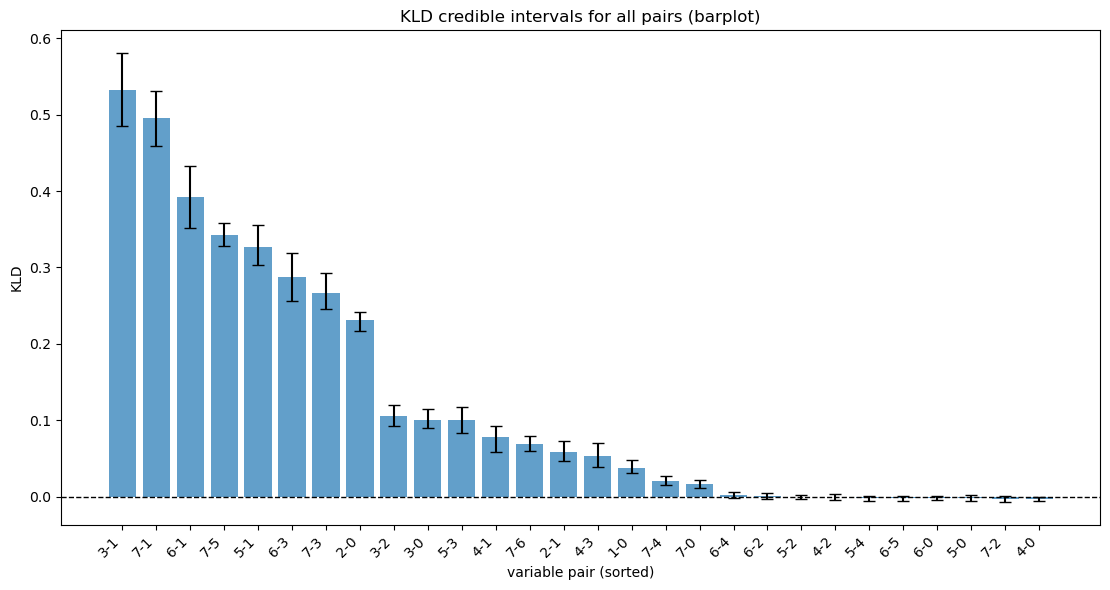

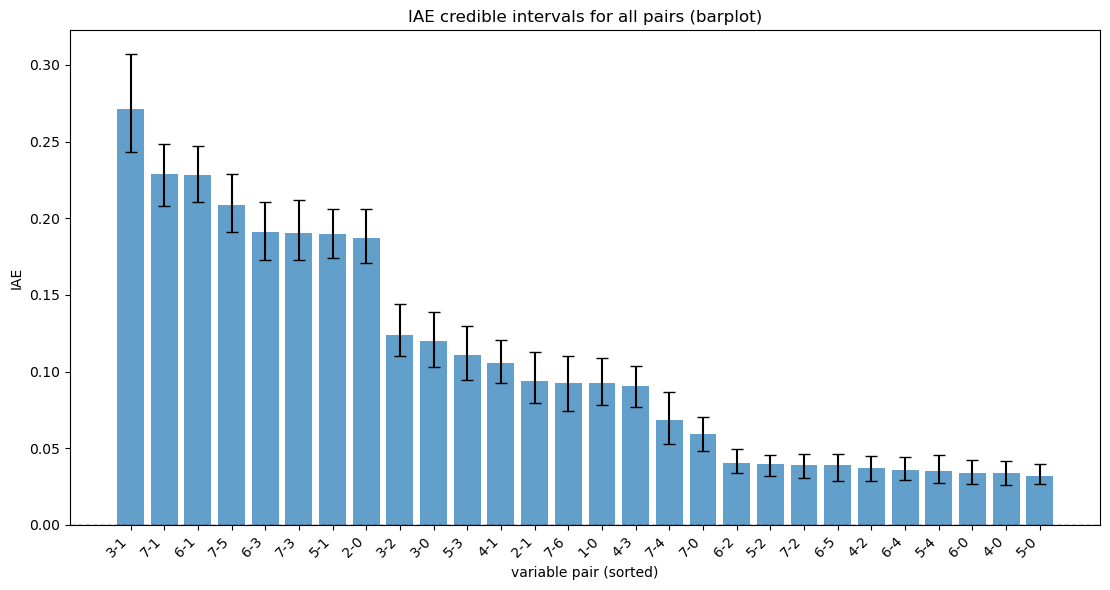

In [26]:
plot_metric_bar_ci(df_ci, metric="kld", log_scale=False)
plot_metric_bar_ci(df_ci, metric="iae", log_scale=False)


In [27]:
#CI_groups = theta_ci_by_group(VI, level=0.95, sort_within_group=True)

#if CI_groups["transformation"] is not None:
#    plot_theta_ci_group(CI_groups["transformation"], "Transformation", max_params=200)

#if CI_groups["decorrelation"] is not None:
#    plot_theta_ci_group(CI_groups["decorrelation"], "Decorrelation", max_params=200)


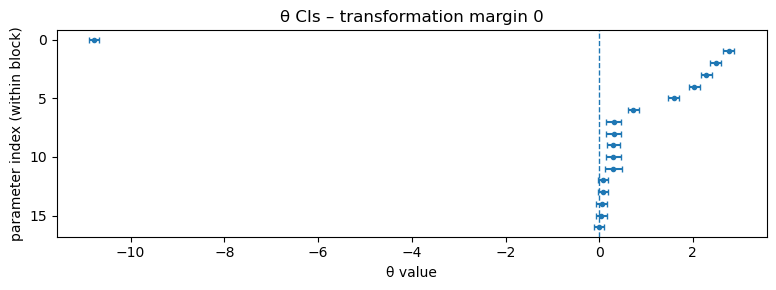

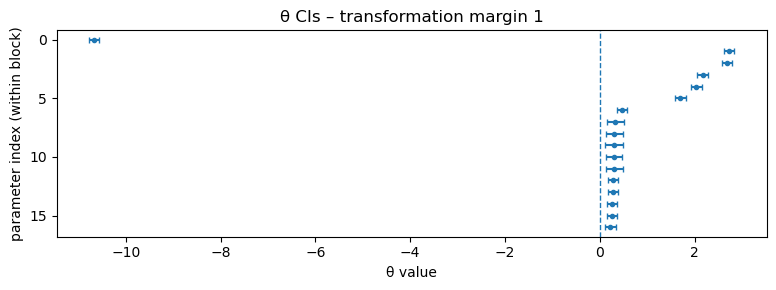

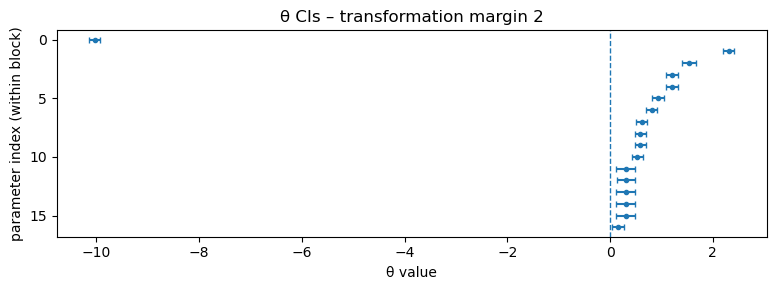

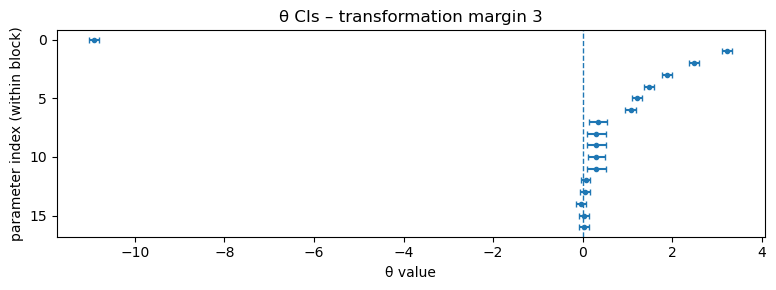

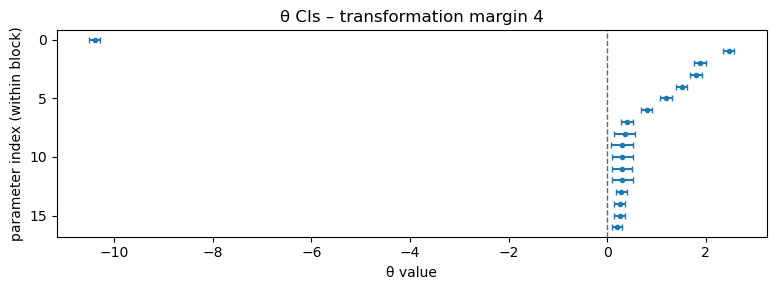

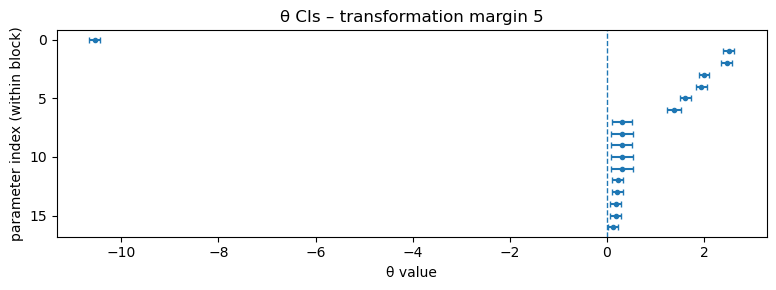

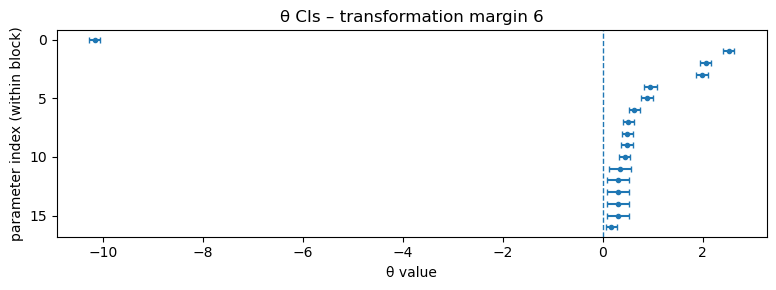

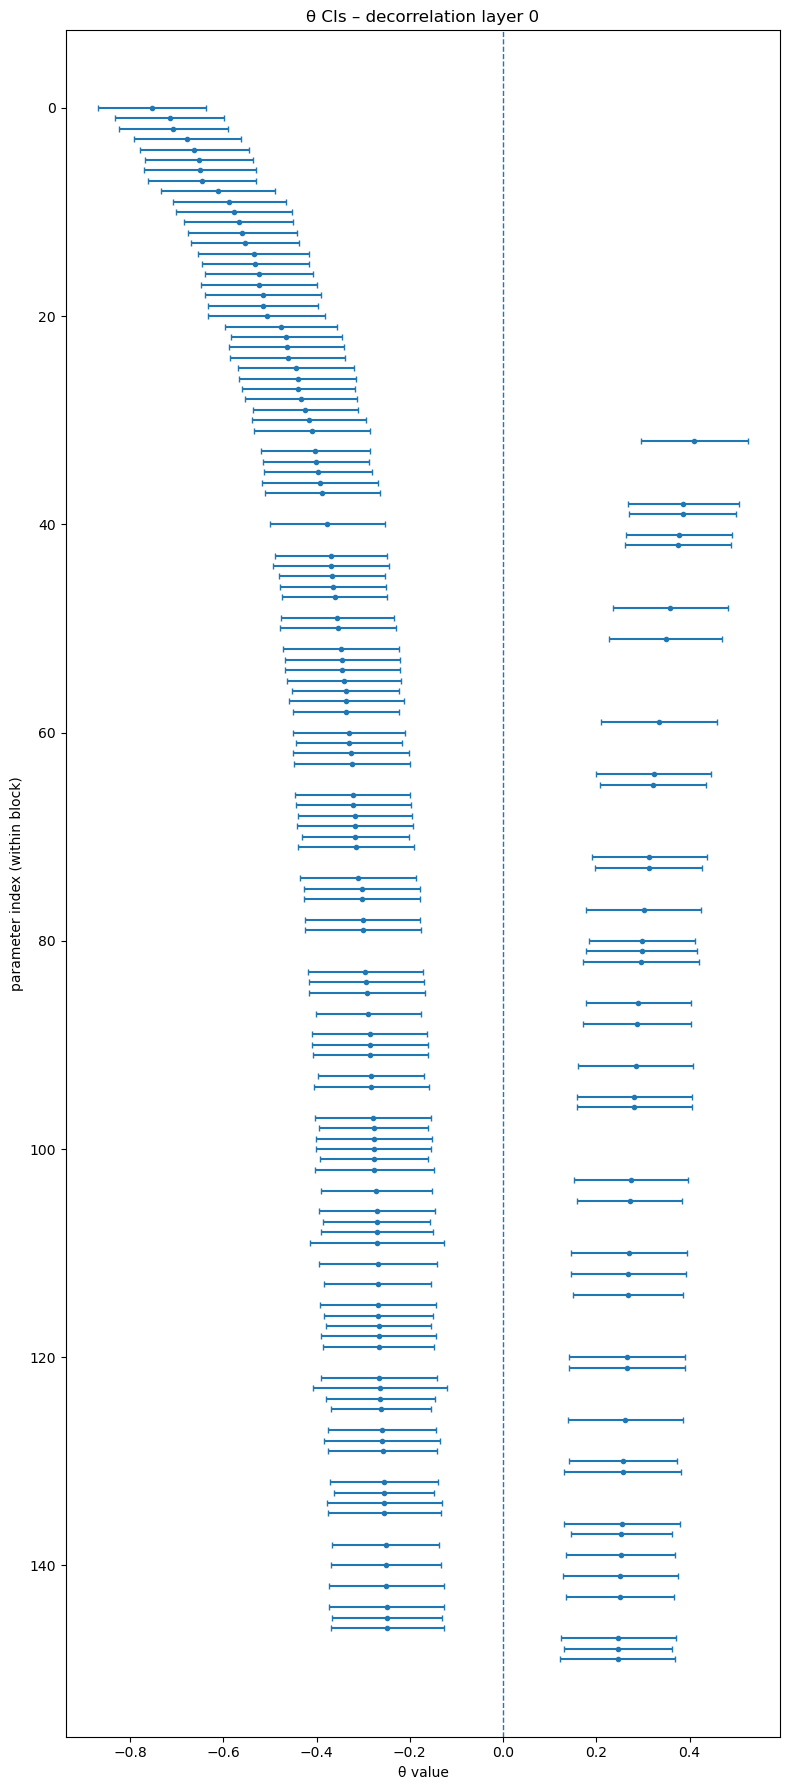

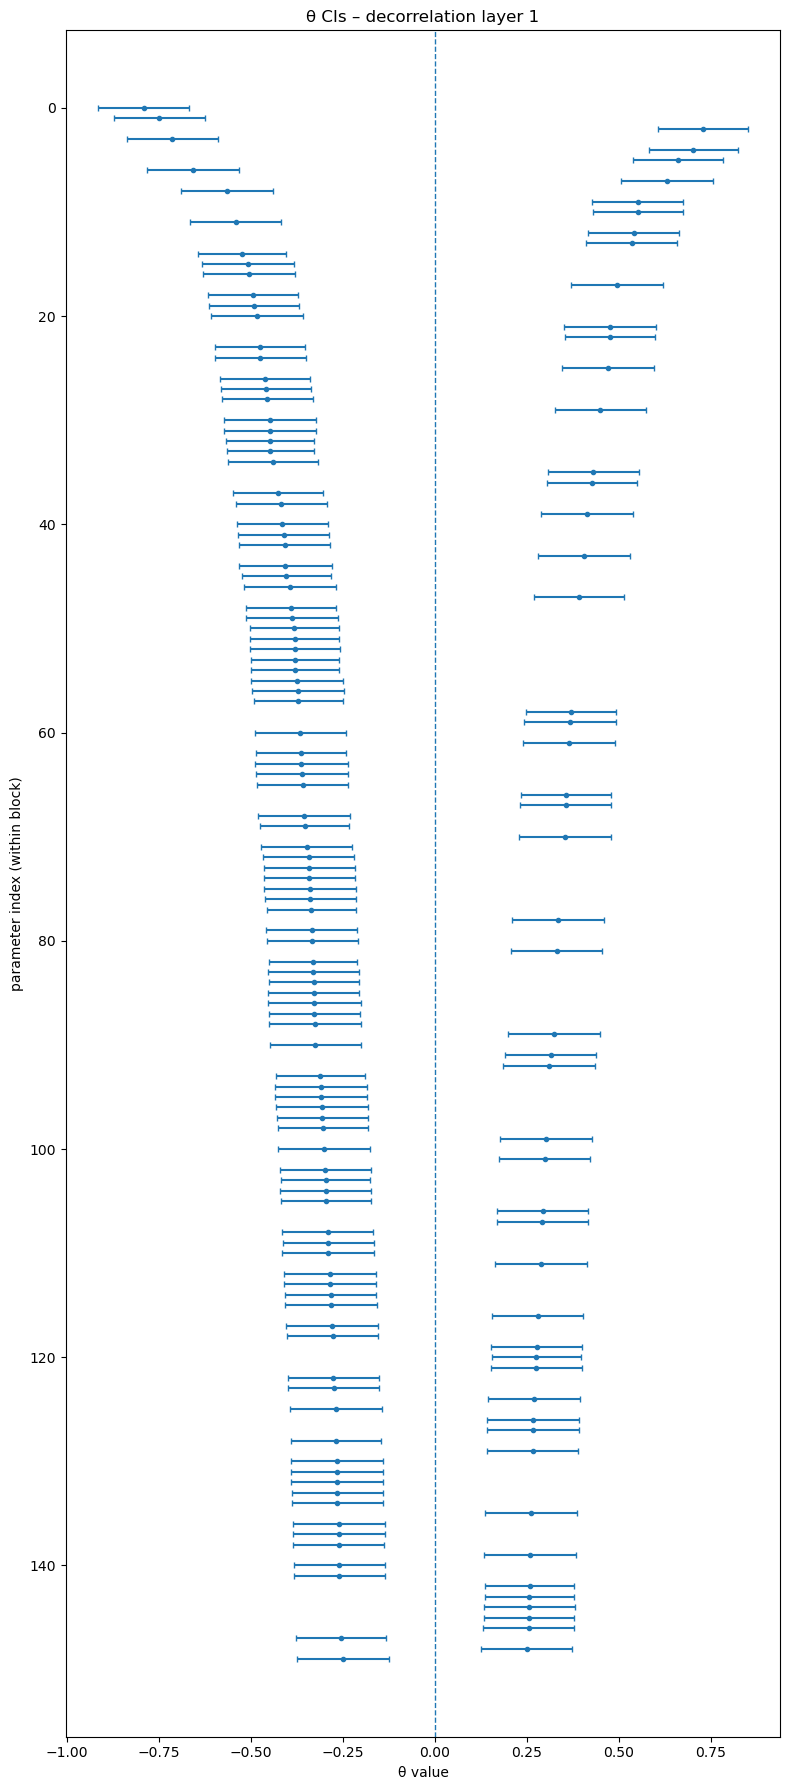

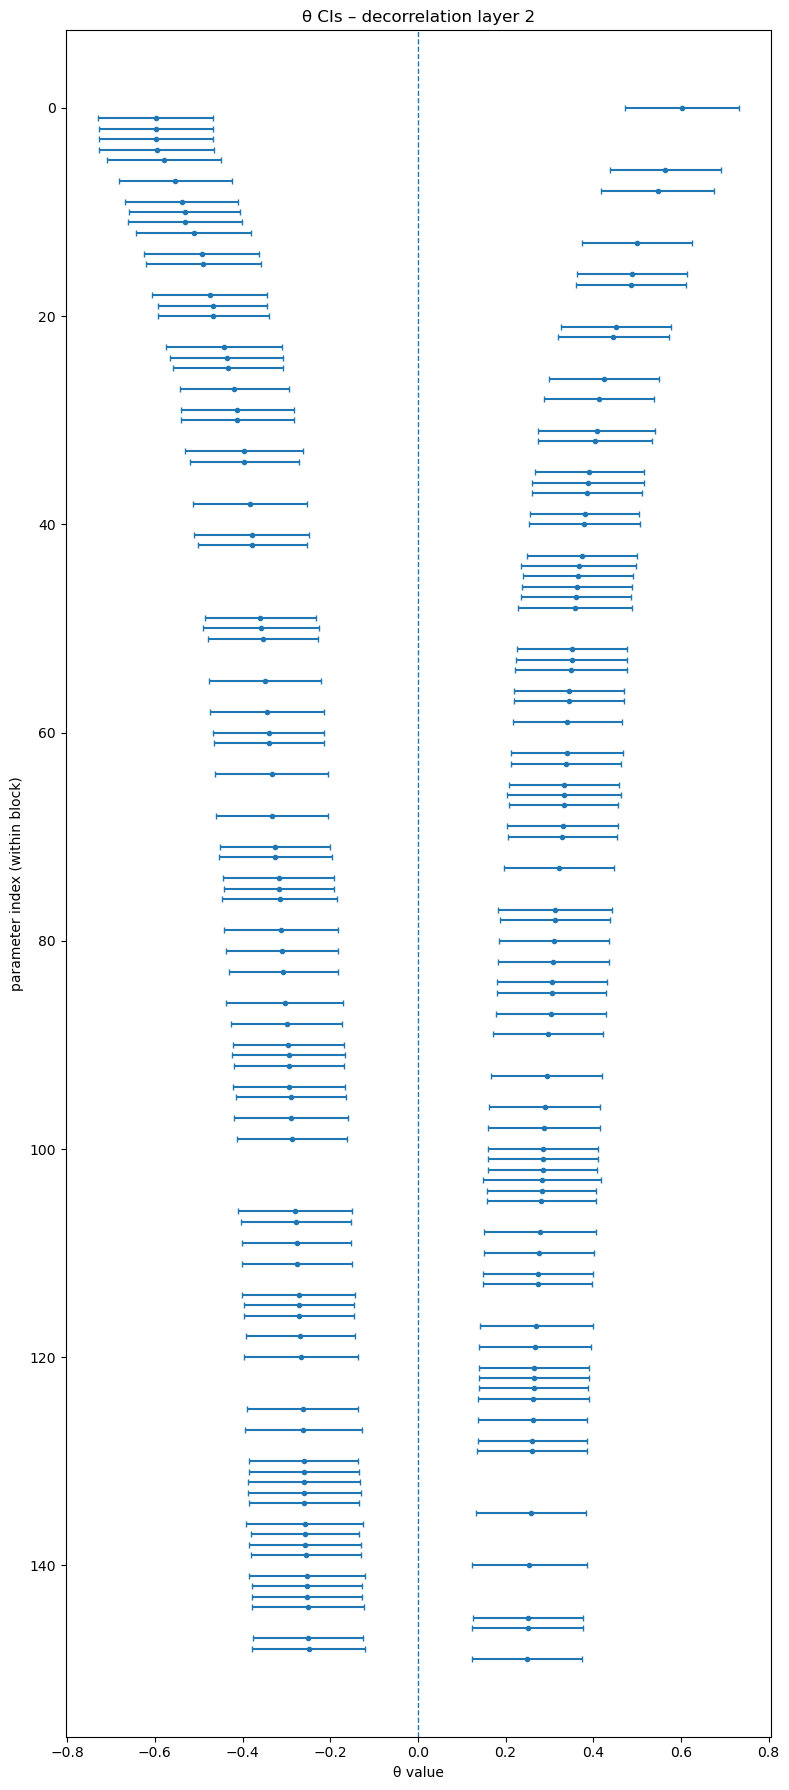

In [28]:
ci_blocks = theta_ci_by_schema(VI, level=0.95, sort_within_group=True)

# Transformation per margin
for j in range(7):
    key = f"transformation.params.{j}"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – transformation margin {j}", max_params=150)

# Decorrelation layers
for ℓ in range(3):
    key = f"decorrelation_layers.{ℓ}.params"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – decorrelation layer {ℓ}", max_params=150)


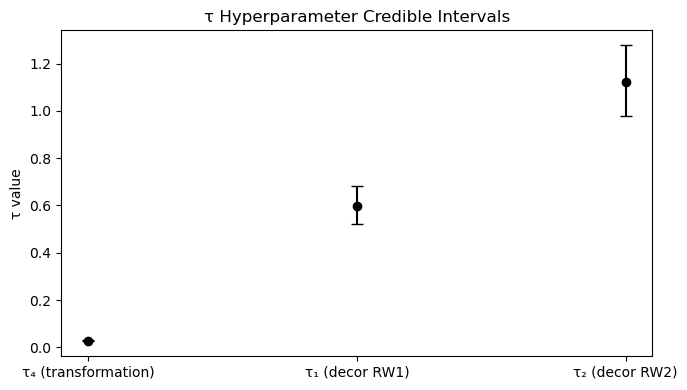

In [29]:
ci_4 = tau_ci_from_node(tau_nodes.node4)
ci_2 = tau_ci_from_node(tau_nodes.node2)
ci_1 = tau_ci_from_node(tau_nodes.node1)

tau_info = [
    ("τ₄ (transformation)", ci_4["mean"], ci_4["lower"], ci_4["upper"]),
]
if True: ### decor_present output from train method
    tau_info += [
        ("τ₁ (decor RW1)", ci_1["mean"], ci_1["lower"], ci_1["upper"]),
        ("τ₂ (decor RW2)", ci_2["mean"], ci_2["lower"], ci_2["upper"]),
    ]
plot_tau_nodes(tau_info)

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [30]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1289: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]
[FIX] var 7: valid interval = [-9.999999, 9.999999]


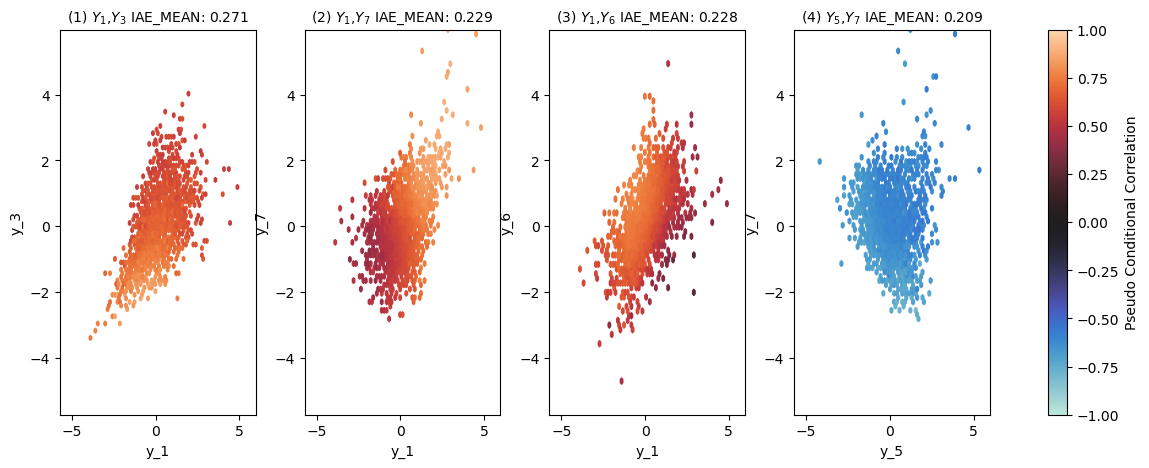

In [31]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

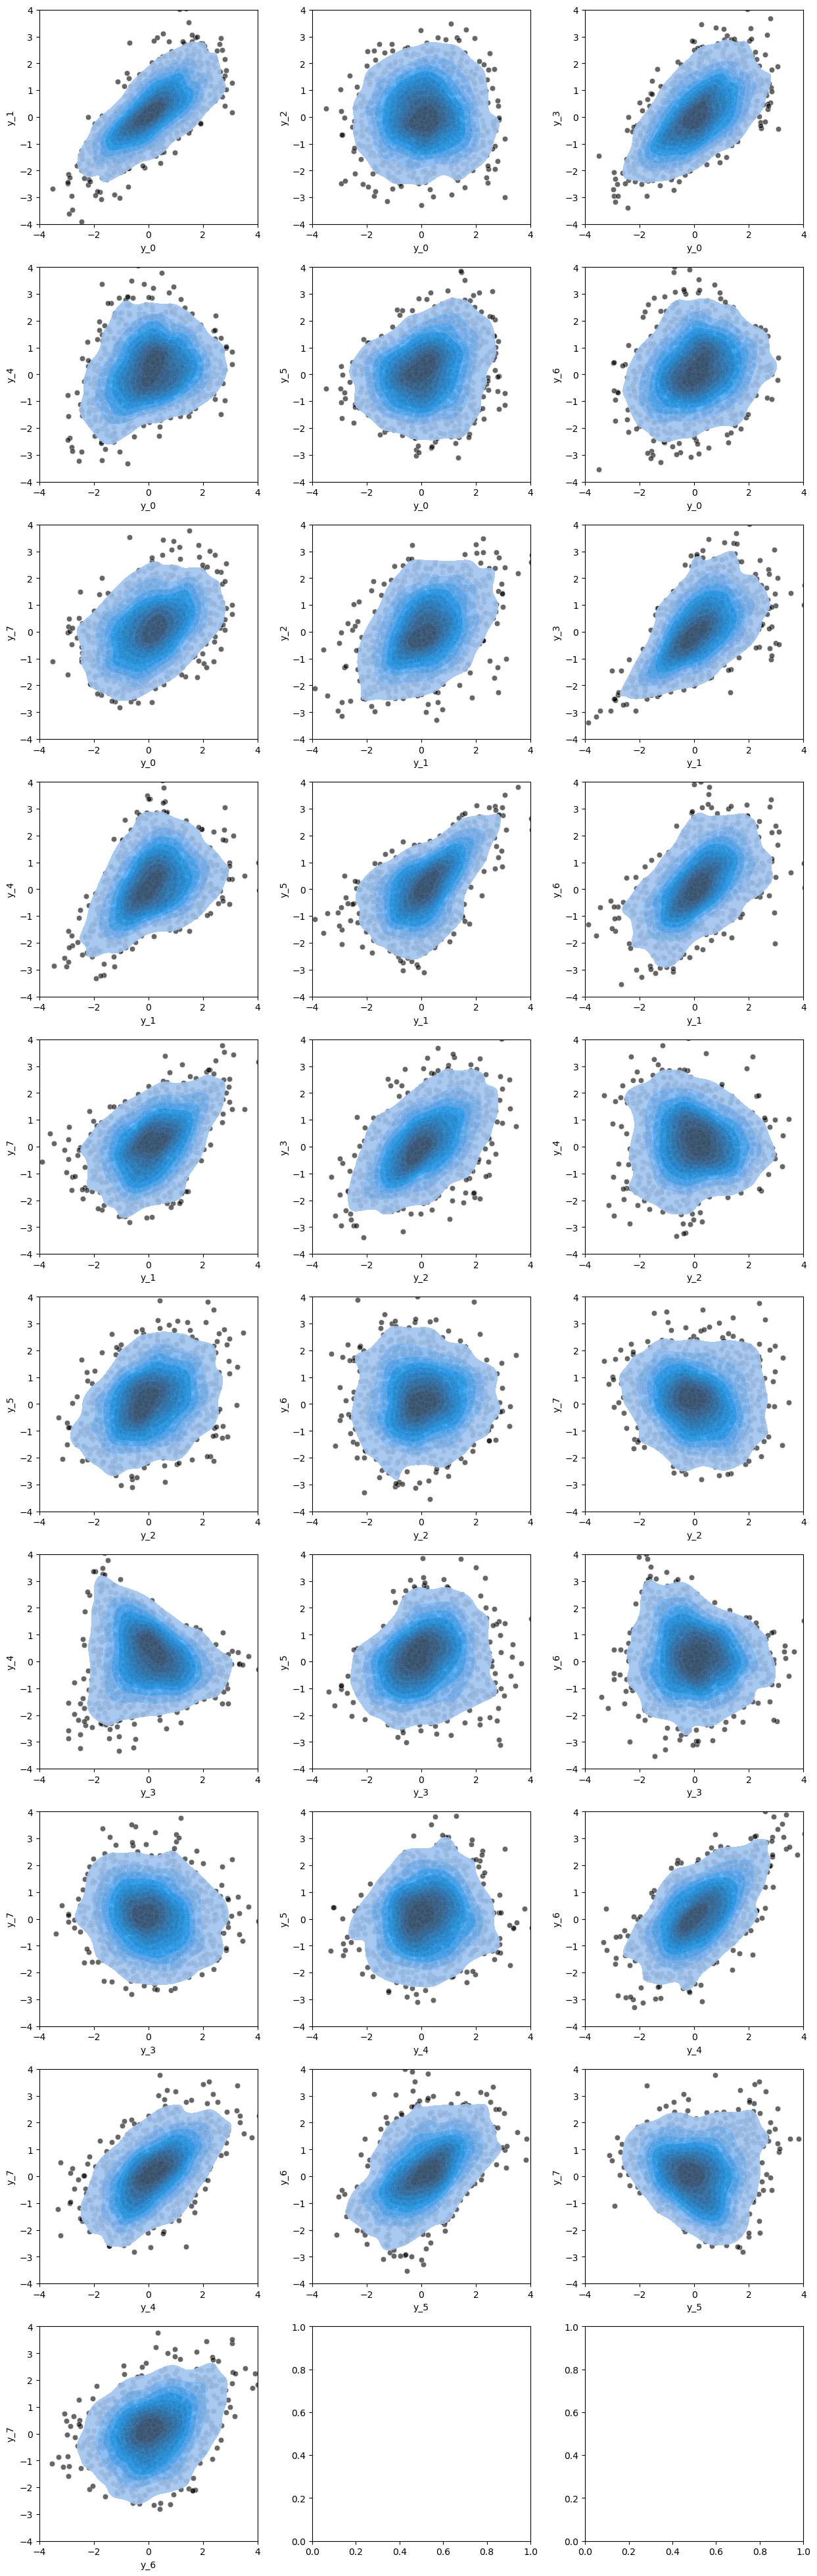

In [32]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [33]:
#model.plot_splines(layer_type="transformation")

In [34]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [35]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [36]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [37]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [38]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [39]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.982607,0.619978,-0.010947,0.309797,-0.154351,0.336617,0.343733,0.314724,0.311440,...,0.064039,0.069513,0.082649,-0.017515,-0.025178,-0.018610,0.000547,-0.036672,0.008758,-0.252660
var_row,0.982607,1.000000,0.470238,-0.007520,0.259856,-0.132853,0.278517,0.287151,0.259578,0.256793,...,0.051526,0.054589,0.068515,-0.028409,-0.028409,-0.019775,-0.004456,-0.037321,-0.001114,-0.252622
var_col,0.619978,0.470238,1.000000,-0.047626,0.368478,-0.149842,0.402735,0.399672,0.389645,0.382961,...,0.065730,0.078263,0.087176,0.038435,-0.004456,-0.002785,0.024509,-0.006963,0.041499,-0.121800
abs_mean,-0.010947,-0.007520,-0.047626,1.000000,-0.245211,0.885605,-0.249042,-0.244116,-0.256158,-0.255063,...,0.960044,0.954023,0.958402,0.944171,0.948550,0.944718,0.964423,0.957854,0.955118,0.766847
mean,0.309797,0.259856,0.368478,-0.245211,1.000000,-0.323481,0.969896,0.974822,0.988506,0.991242,...,-0.152162,-0.175698,-0.171866,-0.215654,-0.196497,-0.197044,-0.209633,-0.249042,-0.204160,-0.359044
std,-0.154351,-0.132853,-0.149842,0.885605,-0.323481,1.000000,-0.392447,-0.383142,-0.357964,-0.358511,...,0.800219,0.796935,0.808429,0.827586,0.823207,0.830870,0.869184,0.864258,0.849480,0.740251
min,0.336617,0.278517,0.402735,-0.249042,0.969896,-0.392447,1.000000,0.996716,0.984674,0.981390,...,-0.149425,-0.158730,-0.163109,-0.222770,-0.209633,-0.214559,-0.228790,-0.265463,-0.206349,-0.350179
q_1,0.343733,0.287151,0.399672,-0.244116,0.974822,-0.383142,0.996716,1.000000,0.985769,0.983580,...,-0.141762,-0.155993,-0.157635,-0.221675,-0.209086,-0.213465,-0.218938,-0.259989,-0.195950,-0.359044
q_5,0.314724,0.259578,0.389645,-0.256158,0.988506,-0.357964,0.984674,0.985769,1.000000,0.998358,...,-0.155446,-0.170772,-0.172961,-0.217843,-0.204707,-0.211275,-0.217296,-0.256705,-0.201423,-0.350179
q_10,0.311440,0.256793,0.382961,-0.255063,0.991242,-0.358511,0.981390,0.983580,0.998358,1.000000,...,-0.154351,-0.172961,-0.174603,-0.215654,-0.200876,-0.207444,-0.218938,-0.256705,-0.205255,-0.350179


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [40]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.9384615384615385
AUC KLD                    : 0.9333333333333333
AUC Conditional Correlation: 0.8923076923076924
AUC Precision Matrix       : 0.9435897435897436


We further print the ROC Curves for different metrics.

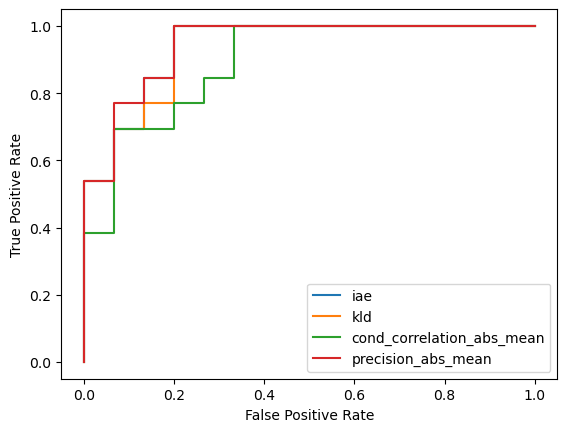

In [41]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()